# Single Cell Tracking Data Processing Notebook

# I. Introduction
This notebook aims to be a general tool for analysis of single cell migration data with use of opensource tools. 

## Existing software

some examples existing tools that this notebook aims to provide with similar functions
### opensource or freeware
1. Chemotaxis and migration tools (Ibidi Gmbh) 
    - https://ibidi.com/manual-image-analysis/171-chemotaxis-and-migration-tool.html
2. Heteromotility from Jacob Kimmel, UCSF 
    - https://github.com/cellgeometry/heteromotility
3. Cell migration analysis platform from AndrewHanSolo
    - https://github.com/andrewhansolo/cmp
4. CellMissy, Ghent U, Belgium
    - https://www.nature.com/articles/srep42383
5. LEVER, Dr. Andrew Cohen, Drexel U
    - http://bioimage.coe.drexel.edu/
6. Lineage Mapper, NIH, US
    - https://pages.nist.gov/Lineage-Mapper/
7. CellProfiler tracer
    - http://cellprofiler.org/tracer/
8. TrackMate
    - https://imagej.net/TrackMate
9. Icy track Manager
    - http://icy.bioimageanalysis.org/plugin/Track_Manager
10. Celltracker
    - http://www.celltracker.website/index.html
11. MotilityLab
    - http://www.motilitylab.net/
12. fastER, Dr. Timm Schroeder Group, ETH Zürich
    - https://www.bsse.ethz.ch/csd/software/faster.html
13. cell tracking from brikeats, Dr. Ed munro's group, U Chicago
    - https://github.com/brikeats/Cell-Tracking
14. iTrack4U, Lionel Larue
    - https://sites.google.com/site/itrack4usoftware/
15. ADAPT, 
    - http://jcb.rupress.org/content/209/1/163.full
        



### Commercial
1. MetaMorph
2. Imaris Track
3. Volocity



## Review papers
1. P-.H. Wu, A. Giri, D. Wirtz, Statistical analysis of cell migration in 3D using the anisotropic persistent random walk model, Nature Protocols, 2015
    - http://www.nature.com/doifinder/10.1038/nprot.2015.030
2. P. Masuzzo, M. van Troys, C. Ampe, L. Martens, Taking Aim at moving targets in computational cell migration, Trends in Cell Biology, 2016 
    - https://www.sciencedirect.com/science/article/pii/S0962892415001658
3. cell shape
    - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3903690/
    
    
## Developers: 
- Tyler Sloan, Ph.D.
>info@Quorumetrix.com
>
- Hsieh-Fu Tsai
>Advisor: Amy Q. Shen, Ph.D. (amy.shen@oist.jp)
>
>Micro/Bio/Nanofluidics Unit, Okinawa Institute of Science and Technology Graduate University, Japan
>
>DC1 Research Fellow of Japan Society for the Promotion of Science
>
>This work was supported by JSPS KAKENHI Grant Number JP1700362.
>
>hsieh-fu.tsai@oist.jp; hsiehfutsai@gmail.com


## Disclaimer:
This notebook is released under the MIT license. 

If you use this code, please cite the following paper:

Hsieh-Fu Tsai, Joanna Gajda, Tyler Sloan, Andrei Rares, and Amy Q. Shen, Usiigaci: Label-free instance-aware cell tracking in phase contrast microscopy using Mask R-CNN, SoftwareX (submitted)


```
Copyright <2018> <Okinawa Institute of Science and Technology Graduate University>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
```

## Software dependencies:

1. Python 3.4+
2. numpy
3. pandas
4. scipy
5. matplotlib
6. seaborn
7. imageio
8. read_roi
9. (jupyter-navbar) for easier navigation in browser
>https://github.com/shoval/jupyter-navbar


## Import data types:

This notebook will process four type of tracking data.
1. tracked results from ImageJ with centroids and cell morphology descriptors (area, circularity, angle)
2. tracked results from Linear Mapper (only centroids)
3. tracked results from Metamorph (only centroids)
4. tracked results from trackpy based tracker

Alternatively, you can read into the code to adjust the data loading interface to match your input data.

## Description of import cell migration parameters
![cell migration](cellmigration.png)
### step centric features 
1. instantaneous displacement of cell between adjacent time points 

    $d_{i}=\sqrt{(x_{i}-x_{i-1})^2+(y_{i}-y_{i-1})^2}$

2. instantaneous speed between adjacent time points

    $s_{i}=d(p_{i-1},p_{i})/\Delta t$

3. turning angle of each cell migration step

    $\alpha_{i}=\tan^{-1}{\frac{(y_{i}-y_{i-1})}{(x_{i}-x_{i-1})}}$

4. Direction autocorrelation (persistence between adjacent steps)

    $dir-aut_{i}=\cos{(\alpha_{i}-\alpha_{i-1})}$
    
5. Directedness

    $Index_{directedness}=\sum\limits_{i=1}^{N} \frac{\cos{\Phi_{i}}}{N} = \sum\limits_{i=1}^{N} \frac{(x_{i}-x_{i-1})}{d_{i}\times N}=\frac{1}{N}\sum\limits_{i=1}^{N} \frac{(x_{i}-x_{i-1})}{\sqrt{(x_{i}-x_{i-1})^2+(y_{i}-y_{i-1})^2}}$

for a cell population moving directly toward positive x the directedness equals to +1; -1 for negative x. A group of cell undergoing random migration has a directedness of 0.

### cell-centric features
6. cumulative distance (total distance travelled)

    $d_{total}=\sum\limits_{i=1}^{N} d(p_{i-1},p_{i})$

7. Euclidean distance (net trigonometric distance travelled)

    $d_{net}=d(p_{0},p_{N})=\sqrt{(x_{N}-x_{0})^2+(y_{N}-y_{0})^2}$
    
8. net velocity 
    
    $\bar{v}_{net}=\frac{d_{net}}{t_{elapsed}}$

10. end-point directionality ratio (confinement ratio, meandering index)

    $ep\_dr = \frac{d_{net}}{d_{tot}}$
    
11. mean curvilinear speed

    $\bar{v} = \frac{1}{N-1} \sum\limits_{i=1}^{N-1} v_{i}$
    
12.  Acircularity (inverse of circularity) 

    $a=\frac{P^{2}}{4\pi A}$
    
13. Mean squared displacement

    $MSD = \frac{1}{N-n} \sum\limits_{i=1}^{N-n} d^{2}(p_{i}, p_{i+n})$

14. Orientation

    $Index_{orientation}=\sum\limits_{i=1}^{N} \frac{\cos{2\theta_{i}}}{N}$
    
    for a cell aligning perpendicularly the orientation is -1, for a cell aligning parallely the oreintation is 1. for a group of cells aligning randomly the orientation is close to 0.


# II. Import necessary libraries

In [1]:
#Import all libraries for loading data and plotting
import numpy as np
import pandas as pd
import scipy

from IPython.core.display import display
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook 
#notebook style seems to cause some errors in scatter plots
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

import os
import imageio

from read_roi import read_roi_file
from read_roi import read_roi_zip

#at somepoint uses plotly for the plots that will benefit from interactivity maybe useful for html presentation but not for publication

# III. import results

## III.1 Define experimental parameters

In [2]:
#define the frames throughout the experiments
n_frames = 37
# define the time interval between each frame
t_inc = 10 # in minutes
print("Total frame of time lapse is %d" %(n_frames))
print("Time interval is %d minutes"%(t_inc))

Total frame of time lapse is 37
Time interval is 10 minutes


## III.2 Import imageJ tracked results into pandas
the data should be arranged by individual cells throughout a time frame such as 
>cell id - frame
>
>1 - 0
>
>1 - 1
>
>1 - 2
>
>...
>
>1 - 37
>
>2 - 0
>
>2 - 1
>
>... 
>


In [3]:
#read csv files from imageJ into pandas dataframe
location = r'D:\Cell electrotaxis\20180603similarity_analysis\maskrcnn tracking\16-1_10min\Results_calibrated.csv'
#location = 'Results_calibrated.csv'
#load imageJ multimeasure data
df_ij = pd.read_csv(location)
# show the ImageJ spreadsheet as a Pandas dataframe
#display(df_ij)
n_cells_ij = int(len(df_ij) / n_frames)
timestamps = np.linspace(0, n_frames*t_inc, n_frames+1)
#data_imageJ= True
data_type='ImageJ'
print("Cell track numbers is %d"%(n_cells_ij))

Cell track numbers is 14


### III.3 import Lineage Mapper tracked results (trk-positions.csv) into pandas
note that in linemapper, cell that disappeared during segmentation, divided (mitosis) or fused will cause a break in lineage. 
After loading the data, the following code will only look for a cell ID that successfully identified throughout all frames.

In [9]:
#Use data from lineage mapper.
positions = r'D:\Cell electrotaxis\20180603similarity_analysis\Deepcell\16-1LMresults\trk-positions.csv'
df_LM = pd.read_csv(positions)
#print(df_ij.to_string())
# need to have a code for data preprocessing by excluding the cells that weren't existing throughout all the frames.
#This code will go into the cellID and look for the ones have get identified as many times as the frame number 
#(get identified and tracked all the way)
count = df_LM['Cell ID'].value_counts()
cell_ids_LM = count[count==n_frames].index.tolist()
n_cells_LM = int(len(cell_ids_LM))
timestamps = np.linspace(0, n_frames*t_inc, n_frames+1)
print("Cell track number is: " + str(n_cells_LM))
#create a new dataframe to save only the fully tracked data
col_names = df_LM.columns.tolist()
selected_df = pd.DataFrame(columns=col_names)
for i in cell_ids_LM:
    selected_df = selected_df.append(df_LM.loc[df_LM['Cell ID']==i].copy())
#print(selected.to_string())
#save the selected dataframe to a new csv
selected_df.reset_index(drop=True, inplace=True)
#selected_df.to_csv("processed-trk-positions.csv", header=True, index=False)
#data_imageJ=False
data_type = 'LineageMapper'

Cell track number is: 0


### III.4 Import Metamorph tracked results into pandas

In [4]:
positions = r'D:\Cell electrotaxis\20180603similarity_analysis\3T3Ctrl\Metamorph\total_metamorph.csv'
df_meta = pd.read_csv(positions)
count = df_meta['Object #'].value_counts()
cell_ids_meta = count[count==n_frames].index.tolist()
n_cells_meta = int(len(cell_ids_meta))
timestamps = np.linspace(0, n_frames*t_inc, n_frames+1)

print("Cell track number is:" + str(n_cells_meta))
col_names = df_meta.columns.tolist()
selected_df = pd.DataFrame(columns=col_names)
for i in cell_ids_meta:
    selected_df = selected_df.append(df_meta.loc[df_meta['Object #']==i].copy())
selected_df.reset_index(drop=True, inplace=True)
data_type = 'Metamorph'

Cell track number is:86


### III.5 Import Usiigaci tracked results into pandas

In [5]:
location = r'C:\Users\Davince\Dropbox (OIST)\Deeplearning_system\tracking project\Data\T98G_Exp_2018-08-19T165942\tracks.csv'
df_usiigaci = pd.read_csv(location)
count = df_usiigaci['particle'].value_counts()
cell_ids_usiigaci = count[count==n_frames].index.tolist() # finding only cells that exist through all the framee
n_cells_usiigaci = int(len(cell_ids_usiigaci))
timestamps = np.linspace(0, n_frames*t_inc, n_frames+1)
print("Cell track number is:" + str(n_cells_usiigaci))
col_names = df_usiigaci.columns.tolist()
selected_df = pd.DataFrame(columns=col_names)
for i in cell_ids_usiigaci:
    selected_df = selected_df.append(df_usiigaci.loc[df_usiigaci['particle']==i].copy())
selected_df.reset_index(drop=True, inplace=True)
data_type='usiigaci'

Cell track number is:34


# IV. Data processing

## IV.1 process the ImageJ data to extract area, perimeter, angle, and circularity at each time point for each cell.

In [6]:
if data_type=='ImageJ':
    display(df_ij)
else:
    display(selected_df)

particle  frame        y        x  equivalent_diameter  perimeter  \
0           2    0.0  733.490  688.717               49.379    177.238   
1           2    1.0  733.486  688.125               49.417    184.894   
2           2    2.0  733.817  685.924               48.006    181.095   
3           2    3.0  729.478  683.573               46.346    161.924   
4           2    4.0  728.584  680.834               45.500    156.953   
5           2    5.0  728.398  677.554               43.541    152.368   
6           2    6.0  726.066  674.519               44.266    158.953   
7           2    7.0  724.010  670.511               44.937    171.853   
8           2    8.0  725.343  672.415               42.295    164.024   
9           2    9.0  725.508  671.148               44.738    168.368   
10          2   10.0  725.720  668.215               44.036    164.953   
11          2   11.0  723.059  665.306               44.852    162.125   
12          2   12.0  721.258  660.772               46.456    168.811   
13          2   13.0  721.012  654.776               47.526    163.882   
14          2   14.0  726.602  654.023               48.165    166.368   
15          2   15.0  728.157  651.060               48.886    169.196   
16          2   16.0  730.513  650.405               49.533    174.652   
17          2   17.0  734.134  649.549               51.598    192.167   
18          2   18.0  738.029  649.151               52.394    194.409   
19          2   19.0  741.351  647.131               53.417    201.338   
20          2   20.0  739.339  647.950               52.138    193.338   
21          2   21.0  742.581  645.815               54.932    216.752   
22          2   22.0  739.270  647.019               52.272    213.196   
23          2   23.0  738.813  646.802               51.015    188.368   
24          2   24.0  739.671  646.224               49.713    199.924   
25          2   25.0  738.889  645.340               48.756    170.953   
26          2   26.0  738.074  642.214               53.820    196.309   
27          2   27.0  737.645  641.749               53.678    189.924   
28          2   28.0  735.284  641.005               54.385    200.510   
29          2   29.0  739.769  638.195               55.989    203.924   
...       ...    ...      ...      ...                  ...        ...   
1228       32    7.0  883.658  727.241               78.882    341.948   
1229       32    8.0  882.463  726.441               78.558    339.262   
1230       32    9.0  884.193  723.623               74.550    333.256   
1231       32   10.0  881.798  720.513               75.912    312.049   
1232       32   11.0  880.329  719.087               76.364    307.806   
1233       32   12.0  881.413  718.233               76.297    302.836   
1234       32   13.0  879.895  715.493               76.080    324.877   
1235       32   14.0  878.481  714.450               77.069    324.291   
1236       32   15.0  878.156  713.078               79.364    337.741   
1237       32   16.0  879.228  713.182               80.914    373.647   
1238       32   17.0  880.303  713.699               81.259    400.375   
1239       32   18.0  881.566  713.360               81.572    370.676   
1240       32   19.0  879.081  711.822               81.907    353.398   
1241       32   20.0  877.581  712.111               81.173    370.333   
1242       32   21.0  879.440  714.228               80.115    368.233   
1243       32   22.0  879.404  715.927               80.297    382.848   
1244       32   23.0  879.094  715.564               76.896    359.019   
1245       32   24.0  877.751  714.772               73.605    356.877   
1246       32   25.0  880.085  715.180               78.485    369.848   
1247       32   26.0  881.744  714.779               80.906    367.706   
1248       32   27.0  882.751  713.747               79.932    344.534   
1249       32   28.0  882.682  709.142               74.044    333.362   
1250     

In [7]:
if data_type=='ImageJ':
    # Process the data into a numpy time-array
    props_t_array = []
    props_t_array = np.empty([n_cells_ij, 14, n_frames]) # Creates a time array, formatted like a spreadsheet, cells in rows, columns for X and Y, and t in Z
    #print(np.shape(props_t_array))
    cell_dfs = []
    ind_i = 0
    i_cell = 0
    for i in range(1,len(df_ij)): # Using 1 instead of zero here avoids indexing -1, but won't skip first row being copied because ind_i initialized as zero above.
        #print(i)
        if(df_ij.loc[i-1,'Slice'] > df_ij.loc[i,'Slice']):
            ind_f = i - 1
            #sub_df = df_ij.ix[ind_i:ind_f,:]        
            sub_df = df_ij.loc[ind_i:ind_f,:]
            print(sub_df)
            ind_i = i
            # Copy the measurements of interest into the numpy array
            props_t_array[i_cell,0,:] = sub_df['X'] # This will be a problem if the number of frames ever differs between cells.
            props_t_array[i_cell,1,:] = sub_df['Y']
            props_t_array[i_cell,2,:] = sub_df['Area']
            props_t_array[i_cell,3,:] = sub_df['Perim.']
            props_t_array[i_cell,4,:] = sub_df['Angle']
            props_t_array[i_cell,5,:] = sub_df['Circ.']
            cell_dfs.append(sub_df) # add also to a list of dataframes
            i_cell = i_cell + 1

    if(i == len(df_ij) - 1): # A special case for the last cell in the results file.
        ind_f = i 
        #sub_df = df_ij.ix[ind_i:ind_f,:]        
        sub_df =df_ij.loc[ind_i:ind_f,:]
        # Copy the measurements of interest into the numpy array
        props_t_array[i_cell,0,:] = sub_df['X'] # This will be a problem if the number of frames ever differs between cells.
        props_t_array[i_cell,1,:] = sub_df['Y']
        props_t_array[i_cell,2,:] = sub_df['Area']
        props_t_array[i_cell,3,:] = sub_df['Perim.']
        props_t_array[i_cell,4,:] = sub_df['Angle']
        props_t_array[i_cell,5,:] = sub_df['Circ.']
    
        # Correct the position coordinates so that all cells start at the same location in the plot.
    zerod_t_array = np.empty([n_cells_ij, 2, n_frames]) # Creates a time array, formatted like a spreadsheet, cells in rows, columns for X and Y, and t in Z

    for i in range(0,n_cells_ij):
        for j in range(0,n_frames):
            zerod_t_array[i,0,j] = props_t_array[i,0,j] - props_t_array[i,0,0]
            zerod_t_array[i,1,j] = props_t_array[i,1,j] - props_t_array[i,1,0]
    print(props_t_array.to_string())
    n_cells = n_cells_ij  
    
       
elif data_type=='LineageMapper':
    print("processing lineage mapper data")
    props_t_array = []
    props_t_array = np.empty([n_cells_LM, 14, n_frames])
    print(np.shape(props_t_array))
    
#     n_cells = len(n_cells_LM)
    n_rows_csv = len(selected_df)
    print('Number of cells: ' + str(n_cells_LM))
    print('Number of rows: ' + str(n_rows_csv))
    
    if(int(n_rows_csv / n_cells_LM) != n_frames): # We can use this to parse the file
        print('Error: improper number of rows in trk file for the number of cells and timepoints.') 
    
    
    
    cell_dfs = []
    ind_i = 0
        
    for i_cell in range(0,n_cells_LM):

        ind_f = ind_i + n_frames - 1
        sub_df = selected_df.loc[ind_i:ind_f,:]
        props_t_array[i_cell,0,:] = sub_df['X Coordinate']
        props_t_array[i_cell,1,:] = sub_df['Y Coordinate']
        # Display the current dataframe and portion of the numpy array.
        display(sub_df)
        print(props_t_array[i_cell,0:2,:])
        ind_i = ind_i + n_frames
    n_cells = n_cells_LM 
    
elif data_type=='Metamorph':
    print("processing metamorph data")
    props_t_array = []
    props_t_array = np.empty([n_cells_meta, 14, n_frames])
    print(np.shape(props_t_array))
    
    n_rows_csv = len(selected_df)
    print('Number of cells: ' + str(n_cells_meta))
    print('Number of rows: ' + str(n_rows_csv))
    
    if(int(n_rows_csv / n_cells_meta) != n_frames): # We can use this to parse the file
        print('Error: improper number of rows in trk file for the number of cells and timepoints.') 
    
    
    
    cell_dfs = []
    ind_i = 0
        
    for i_cell in range(0,n_cells_meta):

        ind_f = ind_i + n_frames - 1
        sub_df = selected_df.loc[ind_i:ind_f,:]
        props_t_array[i_cell,0,:] = sub_df['X']
        props_t_array[i_cell,1,:] = sub_df['Y']
        # Display the current dataframe and portion of the numpy array.
        display(sub_df)
        print(props_t_array[i_cell,0:2,:])
        ind_i = ind_i + n_frames
    n_cells = n_cells_meta

elif data_type == 'usiigaci':
    print("processing Usiigaci data")
    # Process the data into a numpy time-array
    props_t_array = []
    props_t_array = np.empty([n_cells_usiigaci, 14, n_frames]) # Creates a time array, formatted like a spreadsheet, cells in rows, columns for X and Y, and t in Z
    n_rows_csv=len(selected_df)
    print('Number of cells: '+ str(n_cells_usiigaci))
    print('Number of rows: '+str(n_rows_csv))
    if(int(n_rows_csv / n_cells_usiigaci) != n_frames): # We can use this to parse the file
        print('Error: improper number of rows in tracked file for the number of cells and timepoints.') 
    cell_dfs = []
    ind_i = 0

    for i_cell in range(0,n_cells_usiigaci):
        ind_f = ind_i + n_frames - 1
        sub_df = selected_df.loc[ind_i:ind_f,:]
        props_t_array[i_cell,0,:] = sub_df['x']
        props_t_array[i_cell,1,:] = sub_df['y']
        props_t_array[i_cell,2,:] = sub_df['area']
        props_t_array[i_cell,3,:] = sub_df['perimeter']
        props_t_array[i_cell,4,:] = sub_df['angle']
        #props_t_array[i_cell,5,:] = sub_df['solidity']
        # Display the current dataframe and portion of the numpy array.
        #display(sub_df)
        #print(props_t_array[i_cell,0:2,:])
        ind_i = ind_i + n_frames
    n_cells = n_cells_usiigaci
else:
    print("no data found")
#     for i in range(1, len(selected_df)):
#         if(selected_df.loc[i-1,'Frame Number']>selected_df.loc[i, 'Frame Number']):
#             ind_f = i-1
#             sub_df = selected_df.loc[ind_i:ind_f,:]
#             print(sub_df)
#             ind_i=i
#             props_t_array[i_cell,0,:] = sub_df['X Coordinate']
#             props_t_array[i_cell,1,:] = sub_df['Y Coordinate']
#             cell_dfs.append(sub_df)
#             i_cell = i_cell +1
#     if (i == len(selected_df) - 1):
#         ind_f = i
#         sub_df = selected_df.loc[ind_i:ind_f,:]
#         props_t_array[i_cell,0,:]=sub_df['X']
#         props_t_array[i_cell,1,:]=sub_df['Y']
#     zerod_t_array = np.empty([n_cells_LM, 2, n_frames])
    
#     for i in range(0, n_cells_LM):
#         for j in range(0, n_frames):
#             zerod_t_array[i,0,j]=props_t_array[i,0,j] - props_t_array[i,0,0]
#             zerod_t_array[i,1,j]=props_t_array[i,1,j] - props_t_array[i,1,0]

            

processing Usiigaci data
Number of cells: 34
Number of rows: 1258


## IV.2 loop through each time point for each cell, and make calculations relating to the cell migration trajectory through time.

Add the description and information regarding cell migration parameters


In [8]:
for i in range(0,n_cells):
    for j in range(0, n_frames):

        #Segment length
        if(j > 0):
            segment = np.sqrt(pow((props_t_array[i,0,j]-props_t_array[i,0,j-1]),2) 
                                     + pow((props_t_array[i,1,j]-props_t_array[i,1,j-1]),2)) 
        else:
            segment = 0   
        print(i,j,segment)    
        props_t_array[i,6,j] = segment
        
        # Cumulative path length 
        if(j > 0):
            cumulative = cumulative + segment
        else:
            cumulative = 0
        props_t_array[i,7,j] = cumulative

        # Orientation # CURRENTLY: If data_imageJ is false, then this is dealing with NaNs from the empty column of the array. 
        axis_angle = props_t_array[i,4,j]  # Angle of the long axis of the cell: Angle (IJ)??
        orientation = np.cos(2 * np.radians(axis_angle))
        props_t_array[i,8,j] = orientation
                
        # Euclidean distance (From start to current frame)
        if(j > 0):
            euc_dist = np.sqrt(pow((props_t_array[i,0,j]-props_t_array[i,0,0]),2) 
                                     + pow((props_t_array[i,1,j]-props_t_array[i,1,0]),2))
        else:
            euc_dist = 0
        props_t_array[i,9,j] = euc_dist
        
        # Migration speed
        if(j > 0):
            speed = segment / t_inc * 6 # Microns per hour, since t_inc is in minutes 
        else:
            speed = 0 # Or should it be NaN??
            
            
        props_t_array[i,10,j] = speed
         
        # Directedness (Using the calculation from Paul's spreadsheet, where directedness = deltax / radius (euc_distance))
        if(j > 0): # Doesn't make sense to calculate this on the first frame.
            directedness = (props_t_array[i,0,j]-props_t_array[i,0,0]) / euc_dist
        else: 
            #directedness = np.nan
            directedness = 0
        
        props_t_array[i,11,j] = directedness       
        
        # Turn angle
        if(j > 0): # Doesn't make sense to calculate this on the first frame.
            turn_angle_radians = np.arctan((props_t_array[i,1,j] - props_t_array[i,1,j-1]) / (props_t_array[i,0,j] - props_t_array[i,0,j-1]))
            turn_angle = np.degrees(turn_angle_radians)
        else: 
            turn_angle = 0
            #turn angle is defined arbitrarily 0 at first frame
            #arctan returns radians

        props_t_array[i,12,j] = turn_angle
        
        # Endpoint directionality ratio (confinement ratio, meandering index)
        if(j > 0):
            ep_dr = cumulative / euc_dist # This is problematic because segment uses i+1 - i, whereas euc_dist uses i - 0.
        else: 
            ep_dr = 0
        #endpoint direcionality ratio is defined arbitrarily 0 at first frame 
        
        # Diection autocorrelation
        if(j > 0):
            dir_auto =  np.cos(props_t_array[i,12,j] - props_t_array[i,12,j-1])
        else: 
            #dir_auto = np.nan
            dir_auto = 0
        props_t_array[i,13,j] = dir_auto
        

0 0 0
0 1 0.5920135133592652
0 2 2.2257497613164046
0 3 4.934989564325288
0 4 2.8812075593404223
0 5 3.285269547540931
0 6 3.8274598626243574
0 7 4.504575451693383
0 8 2.3242428874796577
0 9 1.2776987125296142
0 10 2.940651798496373
0 11 3.9424867786715865
0 12 4.878601951379176
0 13 6.001044242463125
0 14 5.640488365381161
0 15 3.3462507377661215
0 16 2.445354984455319
0 17 3.7208032734880017
0 18 3.9152814713632997
0 19 3.887940843171447
0 20 2.1723040763209944
0 21 3.8818538097152047
0 22 3.523114673126624
0 23 0.5059031527871589
0 24 1.034527911658296
0 25 1.1802457371243773
0 26 3.230495472833812
0 27 0.6326657885487463
0 28 2.4754508680238425
0 29 5.2925726258596395
0 30 2.545248514389216
0 31 2.1460067567462
0 32 7.090200913937309
0 33 3.5609556301643424
0 34 0.7314430941638189
0 35 2.5377738275899424
0 36 2.088096022696294
1 0 0
1 1 2.0231482891770667
1 2 0.18023595645711973
1 3 0.21076052761369016
1 4 3.175502637378843
1 5 1.1512467155218962
1 6 0.7041647534490573
1 7 0.598923

17 15 16.86003870102304
17 16 14.788517505145675
17 17 6.773023918457831
17 18 2.300401921404239
17 19 4.0793533801325665
17 20 2.673972512947803
17 21 0.49497474683061543
17 22 0.022203603311084688
17 23 3.57034970276022
17 24 2.2655782926220747
17 25 3.1153622582292906
17 26 2.1924182995040034
17 27 6.066333653863772
17 28 10.901616485640984
17 29 15.466923320428075
17 30 17.96464909203639
17 31 23.662329830344312
17 32 12.598066915205672
17 33 8.81123010708508
17 34 15.99137758293501
17 35 13.178384612690602
17 36 13.383851538327765
18 0 0
18 1 2.87476625136725
18 2 17.014289112390195
18 3 9.301347214248114
18 4 4.919515931471217
18 5 2.479545321223331
18 6 3.2870199269247315
18 7 2.0096629070567014
18 8 2.1036430305543203
18 9 3.360864918439974
18 10 3.647204545950245
18 11 5.792064657788274
18 12 3.786762733523181
18 13 2.4842483772763124
18 14 5.480337580842986
18 15 1.6557768569465585
18 16 0.6694072004393801
18 17 2.881451370403491
18 18 9.416739350751877
18 19 1.11648734878636

30 34 3.355797967697122
30 35 5.00829412075606
30 36 4.5157701447261545
31 0 0
31 1 0.9872466763680888
31 2 0.5333713528115183
31 3 1.571168355078552
31 4 3.91702948674123
31 5 0.8666083313701007
31 6 3.3656767521553497
31 7 1.566811411753201
31 8 0.23721087664795568
31 9 2.5678107406894726
31 10 1.3834637689508897
31 11 2.4714232741479303
31 12 1.3298308163071246
31 13 0.7413851900329185
31 14 0.4615322307272059
31 15 0.37761355907862065
31 16 1.241450764227111
31 17 1.5983303788640588
31 18 0.3542612030691311
31 19 0.7050560261425907
31 20 1.1404266745389866
31 21 1.0677911780868754
31 22 0.9368847314371129
31 23 0.7285801259984088
31 24 6.643569070913756
31 25 4.106353248321363
31 26 18.15563893119715
31 27 3.2814772587966554
31 28 3.4186805934454103
31 29 1.898284752085566
31 30 1.288363302799379
31 31 2.0688146364524256
31 32 0.5904278109981398
31 33 2.0117519727839643
31 34 0.3045389958609642
31 35 0.5572010409178925
31 36 1.955080816743839
32 0 0
32 1 0.9692822086471816
32 2 14.

## IV.3 Create an array containing the zeroed trajectory (adjusted to all start at the origin)

In [9]:
# Correct the position coordinates so that all cells start at the same location in the plot.
zerod_t_array = np.empty([n_cells, 2, n_frames]) # Creates a time array, formatted like a spreadsheet, cells in rows, columns for X and Y, and t in Z

for i in range(0,n_cells):
    for j in range(0,n_frames):
        zerod_t_array[i,0,j] = props_t_array[i,0,j] - props_t_array[i,0,0]
        zerod_t_array[i,1,j] = props_t_array[i,1,j] - props_t_array[i,1,0]


## IV.4 Export the descriptive statistics summary as csv

In [10]:
stats_df = pd.DataFrame(columns=['cell_id','time', 'x_pos_microns', 'y_pos_microns', 'x_pos_corr', 'y_pos_corr',
                                 'area', 'perimeter', 'angle', 'circularity', 'segment_length', 'cumulative_path_length', 
                                 'orientation', 'euclidean_distance', 'speed', 'directedness', 'turn_angle', 'direction_autocorrelation']) #deleted velocity
stats_df.round(4)
summary_cell_df = pd.DataFrame(columns=['cell_id', 'avg_area', 'avg_perimeter', 'avg_angle', 'avg_circularity', 'avg_segment_length', 'total_path_length', 
                                 'avg_orientation', 'euclidean_distance', 'avg_speed', 'avg_velocity', 'avg_directedness', 'avg_turn_angle', 'avg_direction_autocorrelation'])
summary_cell_df.round(2)
summary_timepoint_df = pd.DataFrame(columns=['time', 'avg_area', 'avg_perimeter', 'avg_angle', 'avg_circularity', 'avg_segment_length', 'total_path_length', 
                                 'avg_orientation', 'euclidean_distance', 'avg_speed', 'avg_velocity','avg_directedness', 'avg_turn_angle', 'avg_direction_autocorrelation'])
summary_timepoint_df.round(2)
t = np.linspace(0,(n_frames-1)*t_inc,n_frames)


In [11]:
# Transfer the data from the numpy array back into a dataframe to export to csv
# The computationally intensive, albeit easy to understand way will be 3x nested for loops:
i_row = 0
for i in range(0,len(props_t_array[:,0,0])):
#     for k in range(0,len(props_t_array[0,:,0])):
        for j in range(0,len(props_t_array[0,0,:])):
            stats_df.loc[i_row] = i_row
            stats_df['cell_id'][i_row] = i + 1
            stats_df['time'][i_row] = t[j]
            stats_df['x_pos_microns'][i_row]  = props_t_array[i,0,j] 
            stats_df['y_pos_microns'][i_row] = props_t_array[i,1,j] 
            stats_df['x_pos_corr'][i_row] = zerod_t_array[i,0,j]
            stats_df['y_pos_corr'][i_row] = zerod_t_array[i,1,j]
            stats_df['area'][i_row] = props_t_array[i,2,j]
            stats_df['perimeter'][i_row] = props_t_array[i,3,j]
            stats_df['angle'][i_row] = props_t_array[i,4,j]
            stats_df['circularity'][i_row] = props_t_array[i,5,j]
            stats_df['segment_length'][i_row] = props_t_array[i,6,j]
            stats_df['cumulative_path_length'][i_row] = props_t_array[i,7,j]
            stats_df['orientation'][i_row] = props_t_array[i,8,j]
            stats_df['euclidean_distance'][i_row] = props_t_array[i,9,j]
            stats_df['speed'][i_row] = props_t_array[i,10,j]
            stats_df['directedness'][i_row] = props_t_array[i,11,j]   
            stats_df['turn_angle'][i_row] = props_t_array[i,12,j]
            stats_df['direction_autocorrelation'][i_row] = props_t_array[i,13,j]
            
            i_row = i_row + 1

In [12]:
display(stats_df)

cell_id time x_pos_microns y_pos_microns x_pos_corr y_pos_corr  area  \
0          1    0       688.717        733.49          0          0  1915   
1          1   10       688.125       733.486     -0.592     -0.004  1918   
2          1   20       685.924       733.817     -2.793      0.327  1810   
3          1   30       683.573       729.478     -5.144     -4.012  1687   
4          1   40       680.834       728.584     -7.883     -4.906  1626   
5          1   50       677.554       728.398    -11.163     -5.092  1489   
6          1   60       674.519       726.066    -14.198     -7.424  1539   
7          1   70       670.511        724.01    -18.206      -9.48  1586   
8          1   80       672.415       725.343    -16.302     -8.147  1405   
9          1   90       671.148       725.508    -17.569     -7.982  1572   
10         1  100       668.215        725.72    -20.502      -7.77  1523   
11         1  110       665.306       723.059    -23.411    -10.431  1580   
12         1  120       660.772       721.258    -27.945    -12.232  1695   
13         1  130       654.776       721.012    -33.941    -12.478  1774   
14         1  140       654.023       726.602    -34.694     -6.888  1822   
15         1  150        651.06       728.157    -37.657     -5.333  1877   
16         1  160       650.405       730.513    -38.312     -2.977  1927   
17         1  170       649.549       734.134    -39.168      0.644  2091   
18         1  180       649.151       738.029    -39.566      4.539  2156   
19         1  190       647.131       741.351    -41.586      7.861  2241   
20         1  200        647.95       739.339    -40.767      5.849  2135   
21         1  210       645.815       742.581    -42.902      9.091  2370   
22         1  220       647.019        739.27    -41.698       5.78  2146   
23         1  230       646.802       738.813    -41.915      5.323  2044   
24         1  240       646.224       739.671    -42.493      6.181  1941   
25         1  250        645.34       738.889    -43.377      5.399  1867   
26         1  260       642.214       738.074    -46.503      4.584  2275   
27         1  270       641.749       737.645    -46.968      4.155  2263   
28         1  280       641.005       735.284    -47.712      1.794  2323   
29         1  290       638.195       739.769    -50.522      6.279  2462   
...      ...  ...           ...           ...        ...        ...   ...   
1228      34   70       727.241       883.658     -5.759      1.411  4887   
1229      34   80       726.441       882.463     -6.559      0.216  4847   
1230      34   90       723.623       884.193     -9.377      1.946  4365   
1231      34  100       720.513       881.798    -12.487     -0.449  4526   
1232      34  110       719.087       880.329    -13.913     -1.918  4580   
1233      34  120       718.233       881.413    -14.767     -0.834  4572   
1234      34  130       715.493       879.895    -17.507     -2.352  4546   
1235      34  140        714.45       878.481     -18.55     -3.766  4665   
1236      34  150       713.078       878.156    -19.922     -4.091  4947   
1237      34  160       713.182       879.228    -19.818     -3.019  5142   
1238      34  170       713.699       880.303    -19.301     -1.944  5186   
1239      34  180        713.36       881.566     -19.64     -0.681  5226   
1240      34  190       711.822       879.081    -21.178     -3.166  5269   
1241      34  200       712.111       877.581    -20.889     -4.666  5175   
1242      34  210       714.228        879.44    -18.772     -2.807  5041   
1243      34  220       715.927       879.404    -17.073     -2.843  5064   
1244      34  230       715.564       879.094    -17.436     -3.153  4644   
1245      34  240       714.772       877.751    -18.228     -4.496  4255   
1246      34  250        715.18       880.085     -17.82     -2.162  4838   
1247      34  260       714.779       881.744    -18.221     -0.503  5141   
1

In [13]:
#create avg. statistics of individual cells
#completed 20180527 average of segment length, speed, directedness, turn angle, direction correlation subtracted first frame
for i in range(0,len(props_t_array[:,0,0])):
        summary_cell_df.loc[i] = i
        summary_cell_df['cell_id'][i] = i + 1
        summary_cell_df['avg_area'][i] = np.mean(props_t_array[i,2,:])
        summary_cell_df['avg_perimeter'][i] = np.mean(props_t_array[i,3,:])
        summary_cell_df['avg_angle'][i] = np.mean(props_t_array[i,4,:])
        summary_cell_df['avg_circularity'][i] = np.mean(props_t_array[i,5,:])
        summary_cell_df['avg_segment_length'][i] = np.mean(props_t_array[i,6,1:]) # substract time point 0
        summary_cell_df['total_path_length'][i] = props_t_array[i,7,-1] # Total path length is cumulative path length at final timepoint
        summary_cell_df['avg_orientation'][i] = np.mean(props_t_array[i,8,:]) 
        summary_cell_df['euclidean_distance'][i] = props_t_array[i,9,-1] # Linear distance between first and last point
        summary_cell_df['avg_speed'][i] = np.mean(props_t_array[i,10,1:]) #subtract time point 0
        summary_cell_df['avg_velocity'][i] = props_t_array[i,9,-1] / ((t[-1] - t[0]) / 60) # Total Euclidean distance per hour. 
        summary_cell_df['avg_directedness'][i] = np.nanmean(props_t_array[i,11,1:])#subtract time point 0
        summary_cell_df['avg_turn_angle'][i] = np.nanmean(props_t_array[i,12,1:])#subtract time point 0
        summary_cell_df['avg_direction_autocorrelation'][i] = np.nanmean(props_t_array[i,13,1:])#subtract time point 0

display(summary_cell_df)


cell_id avg_area avg_perimeter  avg_angle avg_circularity  \
0        1  2029.59       187.341   0.105081     1.89162e-34   
1        2  1957.51        184.94   0.116405     1.28519e-39   
2        3   3884.7       332.367  -0.644081     1.67877e-48   
3        4  3276.11       288.148   0.232703    1.09909e+222   
4        5  4107.76       338.164   -1.27749    1.09909e+222   
5        6  3612.43       260.896 -0.0228378    4.35396e+250   
6        7  3946.89        309.53   0.142324    6.77164e+250   
7        8  2136.19       210.522   0.573459    8.94862e+250   
8        9  7322.89       617.452   -1.42535    7.98048e+250   
9       10  3166.65       378.111   -1.14049    7.73979e+250   
10      11  3753.68        358.87 -0.0917568    7.73979e+250   
11      12  1943.35       241.052    1.14519    6.77164e+250   
12      13  3246.95       295.172   0.502757    7.73978e+250   
13      14  4456.24       355.152  -0.520162        0.424405   
14      15  2681.14       218.779  -0.662541       -0.468162   
15      16   4404.3       304.727  -0.538297         10.3784   
16      17  1318.54       172.411   0.557946         582.919   
17      18  3976.62       317.464   0.424405         170.351   
18      19  2845.43        283.35  -0.259324          544.73   
19      20  3604.51       381.398    1.01959          667.27   
20      21  3892.89       298.872   0.181757         267.676   
21      22  4174.11         357.1   -1.18268         513.865   
22      23  4089.76       368.503  -0.724541         209.541   
23      24  1578.68       171.579  -0.454757          207.27   
24      25  5008.78       313.052   -1.05019              18   
25      26  2901.19       252.215   -1.01384              18   
26      27  4593.22       378.536  -0.787324              18   
27      28  2036.32        248.38    0.55773          322.12   
28      29  4796.46       425.129   0.557973         285.408   
29      30  1788.35       173.291   -1.14962          647.01   
30      31  8893.27       397.697   0.392189         803.829   
31      32  990.649       127.247  -0.468162         682.303   
32      33  1049.68       146.052  -0.305216         49.6468   
33      34  4817.22       349.074   -0.37427         59.2812   

   avg_segment_length total_path_length avg_orientation euclidean_distance  \
0             3.08892           111.201        0.999191            54.0172   
1             2.62608           94.5389        0.998745            8.14034   
2             9.53352           343.207        0.998868            201.776   
3              3.6028           129.701        0.998879            62.3985   
4             4.22913           152.249        0.998873            82.0207   
5              4.7279           170.204        0.999309            98.5442   
6             4.12193           148.389        0.999057            64.1452   
7              3.0162           108.583        0.998957            65.4392   
8             5.03083            181.11         0.99876            26.3431   
9             5.65752           203.671        0.998928            74.2684   
10            6.66312           239.872        0.999472            67.7754   
11            6.21823           223.856         0.99897            55.7561   
12            4.89297           176.147        0.999049            107.118   
13            2.98275           107.379        0.998732            37.5514   
14            3.90618           140.623        0.999172            110.621   
15            4.68466           168.648        0.999158            89.0032   
16            6.35435           228.757        0.999122            35.9378   
17            8.42052           303.139        0.999153            30.3703   
18            4.75247           171.089        0.998774            120.599   
19            9.82722            353.78        0.999126              117.8   
20            4.30319           154.915        0.998721            56.1817   
21            5.75401           207.144       

In [14]:
# insert individual time point statistics
#completed 20180527
print(len(props_t_array[0,0,:]))
for i in range(0,len(props_t_array[0,0,:])):
        summary_timepoint_df.loc[i] = i
        summary_timepoint_df['time'][i] = i*t_inc
        summary_timepoint_df['avg_area'][i] = np.mean(props_t_array[:,2,i])
        summary_timepoint_df['avg_perimeter'][i] = np.mean(props_t_array[:,3,i])
        summary_timepoint_df['avg_angle'][i] = np.mean(props_t_array[:,4,i])
        summary_timepoint_df['avg_circularity'][i] = np.mean(props_t_array[:,5,i])
        summary_timepoint_df['avg_segment_length'][i] = np.mean(props_t_array[:,6,i])
        summary_timepoint_df['total_path_length'][i] = np.mean(props_t_array[:,7,i]) # Total path length is cumulative path length at final timepoint
        summary_timepoint_df['avg_orientation'][i] = np.mean(props_t_array[:,8,i])
        summary_timepoint_df['euclidean_distance'][i] = np.mean(props_t_array[:,9,i]) # Linear distance between first and last point
        summary_timepoint_df['avg_speed'][i] = np.mean(props_t_array[:,10,i])
        summary_timepoint_df['avg_velocity'][i] = np.mean(props_t_array[:,9,i]) / ((t[-1] - t[0]) / 60) # Total Euclidean distance per hour. 
        summary_timepoint_df['avg_directedness'][i] = np.nanmean(props_t_array[:,11,i])   
        summary_timepoint_df['avg_turn_angle'][i] = np.nanmean(props_t_array[:,12,i])
        summary_timepoint_df['avg_direction_autocorrelation'][i] = np.nanmean(props_t_array[:,13,i])
        
display(summary_timepoint_df)

37


time avg_area avg_perimeter  avg_angle avg_circularity avg_segment_length  \
0     0  4213.44       304.916  -0.106912     1.3155e+250                  0   
1    10  4112.15       302.302 -0.0548235    2.36907e+250            3.92001   
2    20  4038.03       302.148 -0.0790882         184.654            5.75145   
3    30  3847.85       287.683 -0.0604118     1.2011e+222            4.99535   
4    40  3734.76        290.87     -0.048    3.68457e+250            5.52097   
5    50  3843.82       300.417  0.0102353          182.83            5.96261   
6    60  3922.59       296.181  0.0997647     2.4022e+222            4.62832   
7    70  3775.97       297.458 -0.0491471    4.73814e+250             4.5409   
8    80  3795.35       294.565  -0.227618     1.3155e+250            3.57761   
9    90  3686.74       289.203  -0.228882     2.4022e+222            4.59161   
10  100  3641.41        287.54  -0.249206    4.73814e+250            4.19499   
11  110  3662.85       287.728  -0.119941    3.68457e+250             4.8632   
12  120  3574.35       279.319 -0.0947647    1.72362e+134            4.42623   
13  130   3579.5       283.885  -0.189765    6.49717e+134            5.19747   
14  140  3493.03       290.585  -0.201824     1.3155e+250            3.97253   
15  150  3564.06       294.071  -0.227794    4.34449e+193            4.97368   
16  160  3456.85       291.517  -0.390588     1.3155e+250            5.01515   
17  170  3485.44       298.194  -0.422853    2.36907e+250            4.03142   
18  180  3407.21       296.873  -0.253206    6.05364e+250            4.08675   
19  190  3405.65        294.32  -0.490706     1.2011e+222            4.59538   
20  200  3389.59       296.315  -0.457353    2.36907e+250            3.50005   
21  210  3363.26       298.637  -0.514235    2.36907e+250            4.52732   
22  220  3296.76       301.491  -0.562294    3.68457e+250             6.0001   
23  230  3265.41        299.12  -0.495412    2.35515e+174            4.63599   
24  240  3227.94       295.593  -0.489118     1.3155e+250            4.80568   
25  250  3247.56       302.481  -0.454588     1.3155e+250            4.96431   
26  260  3180.82       299.115  -0.316588         178.914            5.61269   
27  270  3146.09       296.136  -0.516206     1.3155e+250            4.69603   
28  280  3166.71       299.964  -0.307441     2.4022e+222            5.78198   
29  290  3229.97       307.582  -0.328059    4.73814e+250            6.33757   
30  300  3309.65       308.772 -0.0833824     1.2011e+222            5.21053   
31  310  3242.53       301.564 -0.0147059    2.36907e+250            4.93628   
32  320  3210.44       306.768  -0.202588    2.36907e+250            5.72564   
33  330  3029.24       284.731  0.0712353    2.36907e+250            5.50932   
34  340  3094.62       291.854  -0.118794    4.73814e+250             4.4189   
35  350  3097.71       286.349 -0.0645294     1.3155e+250            4.78142   
36  360  2979.35       282.433 -0.0129412    2.34929e+174            5.72447   

   total_path_length avg_orientation euclidean_distance avg_speed  \
0                  0        0.999567                  0         0   
1            3.92001        0.999606            3.92001     2.352   
2            9.67146        0.999528            7.87425   3.45087   
3            14.6668        0.999475            10.4728   2.99721   
4            20.1878        0.999406            12.7115   3.31258   
5            26.1504        0.999414            16.6087   3.57756   
6            30.7787        0.999422            18.3549   2.77699   
7            35.3196        0.999376            20.0019   2.72454   
8            38.8972        0.999363            22.4189   2.14657   
9            43.4888        0.999286            24.7888   2.75497   
10           47.6838        0.999218            26.7081   2.51699   
11            52.547        0.999187              29.31   2.91792   
12           56.9732        0.999164            31.1526   2.65574

In [15]:
export_path = 'export//spreadsheets//'
if not os.path.exists(export_path):
    os.makedirs(export_path)

stats_df.to_csv(export_path + "cell_migration_descriptive_statistics.csv", header=True, index=False)
summary_cell_df.to_csv(export_path + "cell_migration_summary.csv", header=True, index=False)
summary_timepoint_df.to_csv(export_path+"timepoint_migration_summary.csv", header=True, index=False)


# V. Draw the plots

## V.1 Create animated scatter for all the cell positions through time


C:\Users\Davince\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\Davince\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


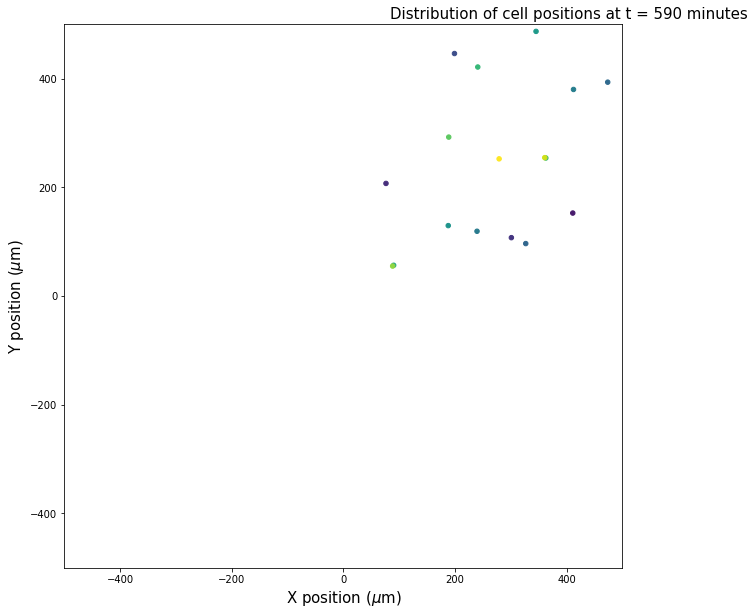

In [13]:
# Set plot limits
xmin = -250
xmax = 250
ymin = -250
ymax = 250

export_path = 'export//scatter//'
if not os.path.exists(export_path):
    os.makedirs(export_path)
    
    
frames = []
fig = plt.figure(frameon=True,facecolor='w')
fig.set_size_inches(10,10)
#ax = plt.Axes(fig, [0., 0., 1., 1.])
#ax.set_axis_off()
#fig.add_axes(ax)
cell_colors = np.linspace(0,1,n_cells)


    
for t in range(0,n_frames):  
    ax=plt.subplot(111)
    ax.clear()
    ax.scatter(props_t_array[:,0,t],props_t_array[:,1,t],s=20,  alpha=1, c=cell_colors)
    #ax.axis('equal')
    ax.axis([xmin, xmax, ymin, ymax]) # Setting the axes like this avoid the zero values in the preallocated empty array.
    #ax.text(250, 1050, 'Distribution of cell positions at t = ' + str(int(timestamps[t])) + ' minutes', fontsize=15)
    ax.text(xmax / 6, ymax + 10, 'Distribution of cell positions at t = ' + str(int(timestamps[t])) + ' minutes', fontsize=15)
    ax.set_xlabel('X position ($\mu$m)', fontsize=15)
    ax.set_ylabel('Y position ($\mu$m)', fontsize=15)    
    # Draw the figure
    fig.canvas.draw()

    # Convert to numpy array, and append to list
    np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    np_fig = np_fig.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(np_fig)
    
imageio.mimsave(export_path + '/scatter_raw.gif', frames)

## V.2 create animated scatter plot for zeroed trajectories


C:\Users\Davince\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\Davince\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


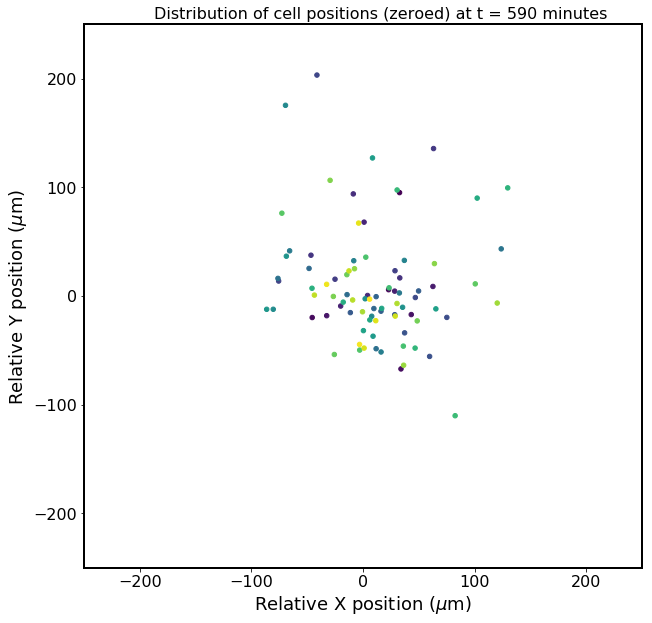

In [44]:
# Set plot limits
xmin = -250
xmax = 250
ymin = -250
ymax = 250

frames = []
fig = plt.figure(frameon=True,facecolor='w')
fig.set_size_inches(10,10)
#ax = plt.Axes(fig, [0., 0., 1., 1.])
#ax.set_axis_off()
#fig.add_axes(ax)
cell_colors = np.linspace(0,1,n_cells)
export_path = 'export//scatter//'
if not os.path.exists(export_path):
    os.makedirs(export_path)
    
for t in range(0,n_frames):
    ax = plt.subplot(111)
    ax.clear()
    ax.scatter(zerod_t_array[:,0,t],zerod_t_array[:,1,t],s=20,  alpha=1, c=cell_colors)
    #ax.axis('equal')
    #plt.axis('off')
    ax.axis([xmin, xmax, ymin, ymax]) # Setting the axes like this avoid the zero values in the preallocated empty array.
    #ax.text(-50, 90, 'Distribution of cell positions (zeroed) at t = ' + str(int(timestamps[t])) + ' minutes', fontsize=15)
    ax.text(xmin + (xmax - xmin) / 8, ymax + 5, 'Distribution of cell positions (zeroed) at t = ' + str(int(timestamps[t])) + ' minutes', fontsize=16)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax.set_xlabel('Relative X position ($\mu$m)', fontsize=18)
    ax.set_ylabel('Relative Y position ($\mu$m)', fontsize=18)

    # Draw the figure
    fig.canvas.draw()
    #uncomment this one if you want to save individual time point into a file
    #plt.savefig(export_path + 'scatter%d.png'%(t), format='png', dpi=600)
    # Convert to numpy array, and append to list
    np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    np_fig = np_fig.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(np_fig)
    
imageio.mimsave(export_path + '/scatter_zerodd.gif', frames)

## V.3 Create a heatmap-timeseries for the zeroed trajectories


C:\Users\Davince\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\Davince\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


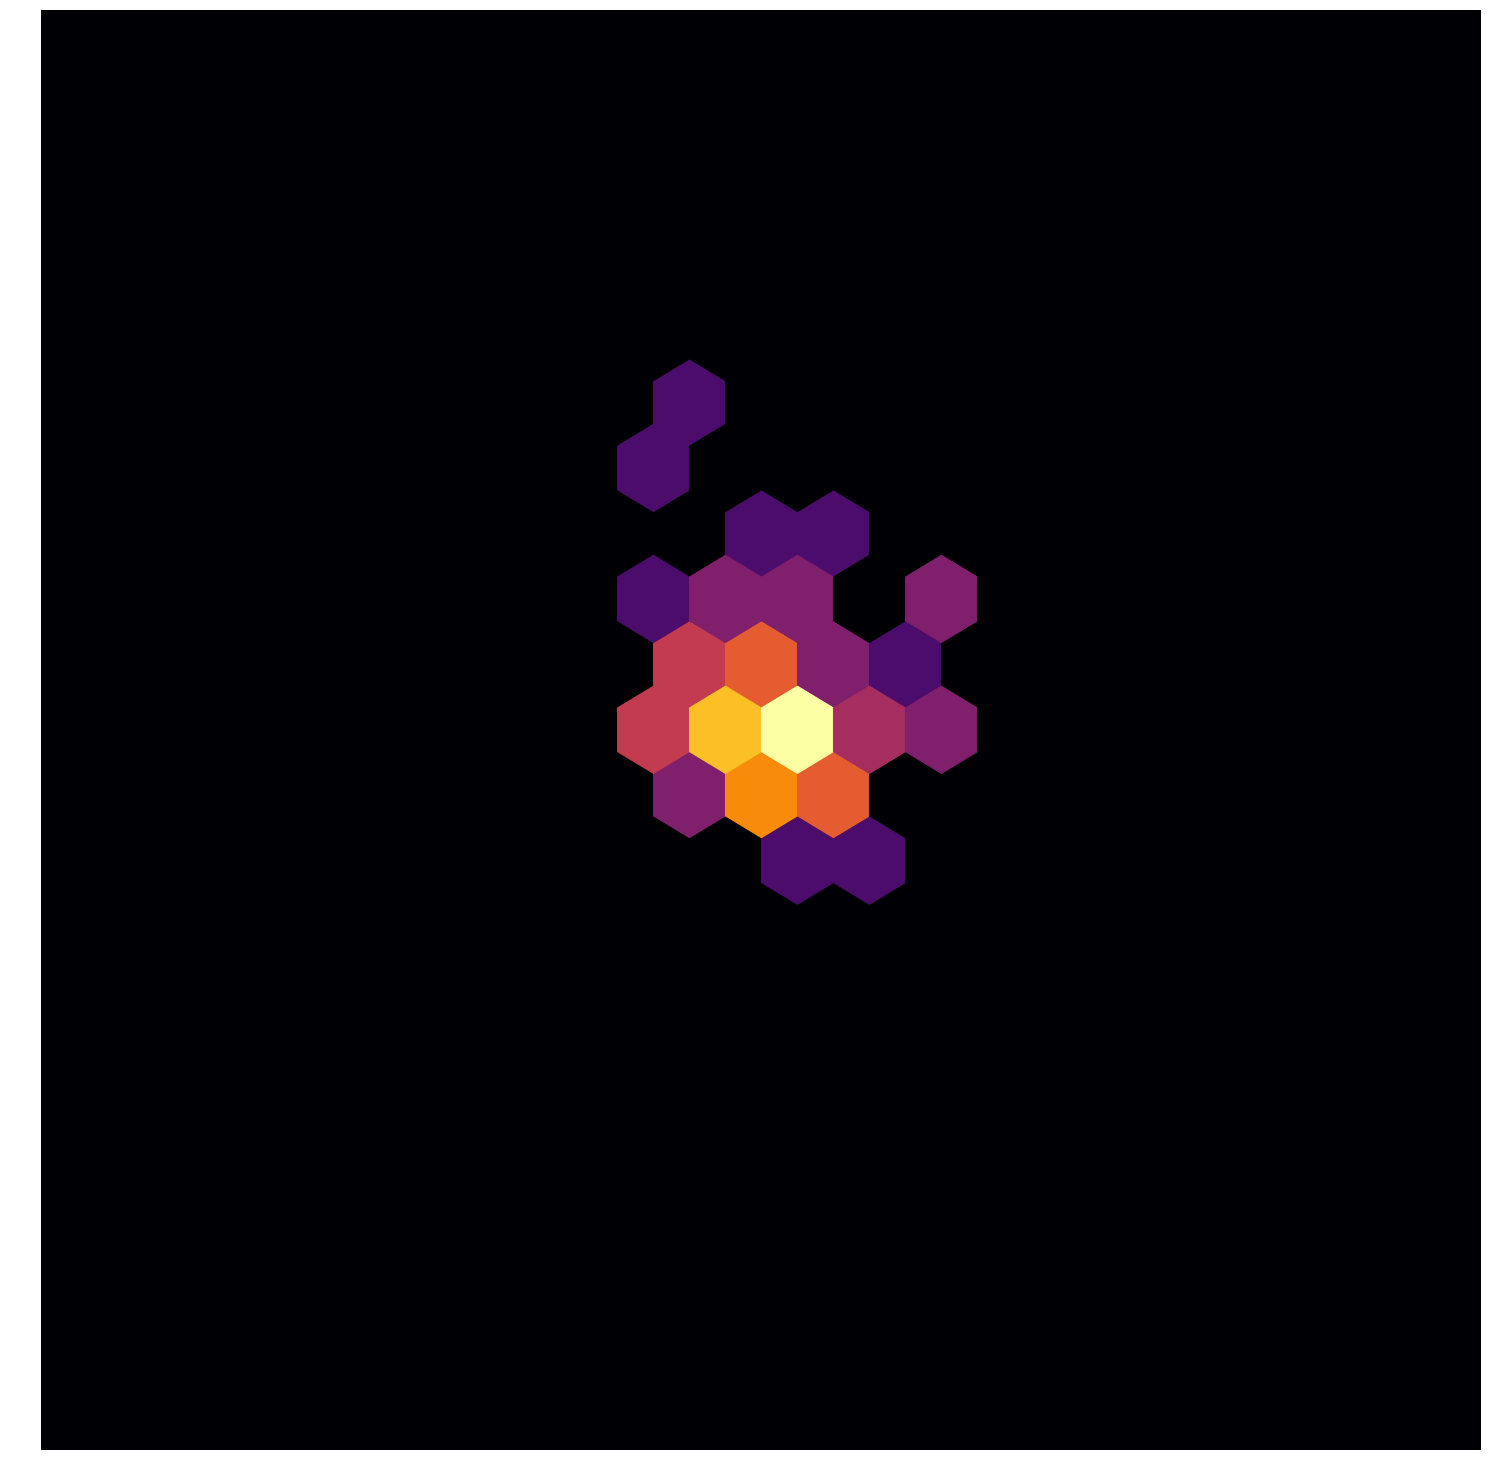

In [15]:
frames = []
num_bins = 20
fig = plt.figure(frameon=False) 
fig.set_size_inches(20,20)

export_path = 'export//hexbin//'
if not os.path.exists(export_path):
    os.makedirs(export_path)

# To make the content fill the whole figure
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()


for t in range(0,len(zerod_t_array[0,0,:])):  

    # Squeeze the current slice of the time array into vectors for x and y.
    x=np.copy(np.squeeze(zerod_t_array[:,0,t]))
    y=np.copy(np.squeeze(zerod_t_array[:,1,t]))


    # Remove the nans from the array
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]

    # Log colormap
    
    hb = ax.hexbin(x, y, gridsize=num_bins, cmap='inferno', bins='log',
                   extent=(xmin, xmax, ymin, ymax))
    
    fig.add_axes(ax)
    ax.axis('equal')
    plt.axis('off')
    ax.axis([xmin, xmax, ymin, ymax]) 
    
    # Draw the figure
    fig.canvas.draw()
    #plt.show()
    # Convert to numpy array, and append to list
    np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    np_fig = np_fig.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(np_fig)
    
imageio.mimsave(export_path + '/hexbin_' + str(num_bins) + '_bins.gif', frames)

## V.4 2D hair ball plots

### V.4.1 each cell track is one color

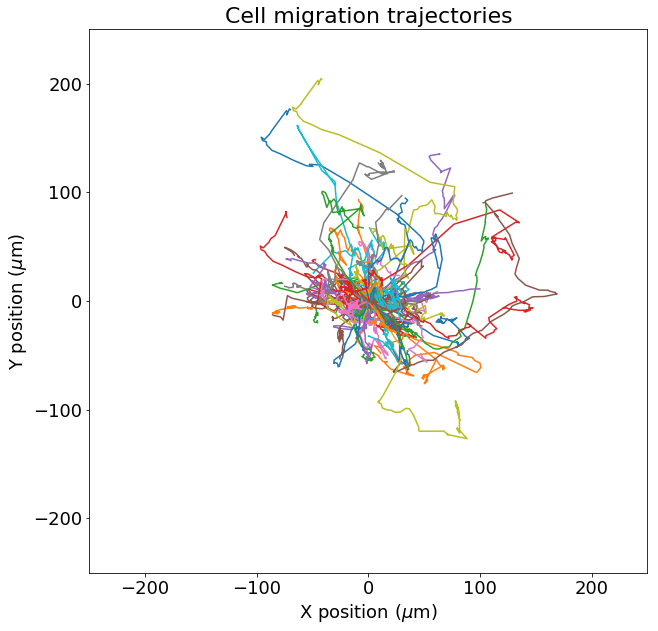

In [18]:
x = zerod_t_array[:,0,:]
y = zerod_t_array[:,1,:]
t = np.linspace(0,n_frames*t_inc,n_frames)
fig = plt.figure(figsize = (10,10),facecolor='w')
ax = fig.add_subplot(111)

export_path = 'export//2d_hairball//'
if not os.path.exists(export_path):
    os.makedirs(export_path)
    
segs = np.zeros((n_cells, n_frames, 2), float)   
segs[:, :, 0] = x
segs[:, :, 1] = y


ax.set_xlim(-250, 250)
ax.set_ylim(-250, 250)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax.set_xlabel('X position ($\mu$m)', fontsize =18)
ax.set_ylabel('Y position ($\mu$m)',fontsize =18)

colors = [mcolors.to_rgba(c)
          for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]

line_segments = LineCollection(segs,colors=colors, cmap=plt.get_cmap('jet'))

ax.add_collection(line_segments)
ax.set_title('Cell migration trajectories',fontsize =22)
#plt.axis('equal')
plt.savefig(export_path + '2d_hairball.png', format='png', dpi=600)
plt.show()   

### V.4.2 2D hairball trajectory plot with color coded according to elapsed time
"Imaris like trajectory map"

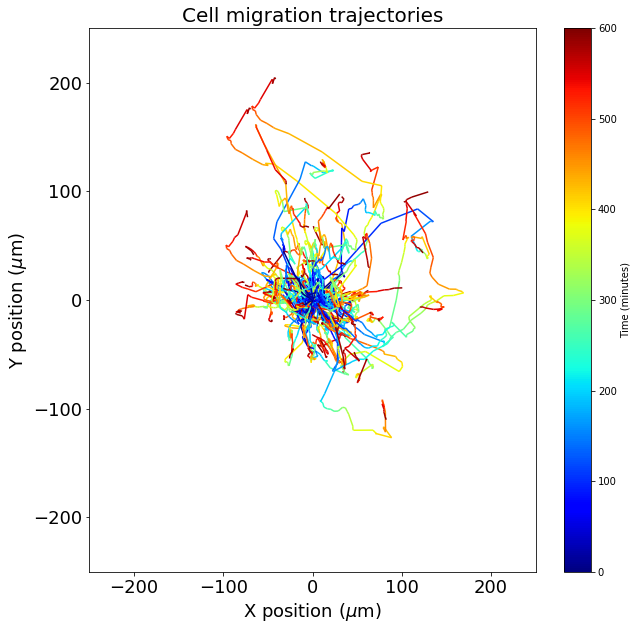

In [20]:
t = np.linspace(0,n_frames*t_inc,n_frames)

fig = plt.figure(figsize = (10,10),facecolor='w')
ax = fig.add_subplot(111)

export_path = 'export//2d_hairball//'
if not os.path.exists(export_path):
    os.makedirs(export_path)
    
    
for n in range(0,n_cells):

    x = zerod_t_array[n,0,:]
    y = zerod_t_array[n,1,:]
    
    # Remove the nans from the array
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    
    # Set the segments in the correct format
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Axis limits and titles
    ax.set_xlim(-250, 250)
    ax.set_ylim(-250, 250)    
    ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
    ax.set_xlabel('X position ($\mu$m)', fontsize=18)
    ax.set_ylabel('Y position ($\mu$m)', fontsize=18)
#     plt.axis('equal')
    # Set the colormap
    cmap=plt.get_cmap('jet')
    line_segments = LineCollection(segments,array=t, cmap=cmap)
    ax.add_collection(line_segments)
    
axcb = fig.colorbar(line_segments)
axcb.set_label('Time (minutes)')
ax.set_title('Cell migration trajectories', fontsize=20)
#plt.axis('equal')
 
plt.savefig(export_path + '2d_hairball_time_cmap.png', format='png', dpi=600)
plt.show()  

### V.4.3 2D hairball plot where color of the entire trajectory is mapped to the final position
"chemotaxis and migration tool(Ibidi)"-like

In [21]:
x = zerod_t_array[:,0,:]
y = zerod_t_array[:,1,:]
end_x_pos = np.empty([len(x[:,0]),1])

for i in range(0,len(end_x_pos)): # For each cell
    x_vals = np.copy(np.squeeze(x[i,:]))
    x_vals = x_vals[~np.isnan(x_vals)]

    if(len(x_vals) > 0):
        end_x_pos[i] = x_vals[-1]
        

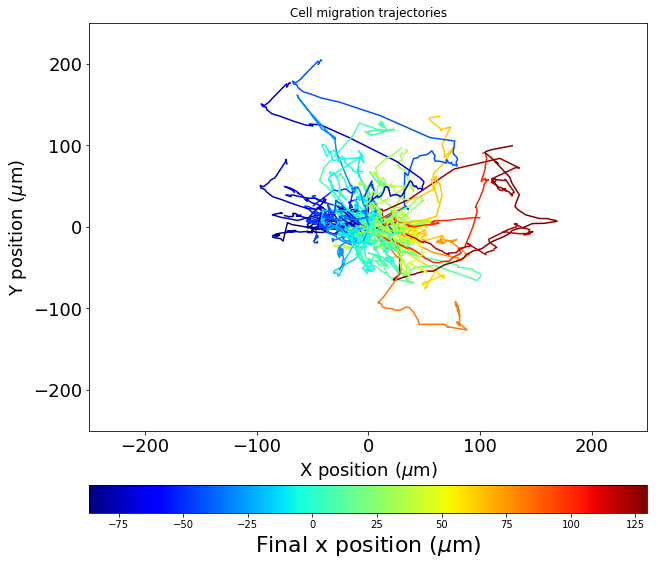

In [22]:
fig = plt.figure(figsize = (10,10),facecolor='w')
ax = fig.add_subplot(111)

export_path = 'export//2d_hairball//'
if not os.path.exists(export_path):
    os.makedirs(export_path)

segs = np.zeros((n_cells, n_frames, 2), float)   
segs[:, :, 0] = x
segs[:, :, 1] = y

#ax.set_xlim(np.nanmin(x), np.nanmax(x))
#ax.set_ylim(np.nanmin(y), np.nanmax(y))
ax.set_xlim(-250, 250)
ax.set_ylim(-250, 250)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax.set_xlabel('X position ($\mu$m)', fontsize=18)
ax.set_ylabel('Y position ($\mu$m)', fontsize=18)

line_segments = LineCollection(segs,array=np.squeeze(end_x_pos), cmap=plt.get_cmap('jet'))
ax.add_collection(line_segments)
ax.set_title('Cell migration trajectories')
axcb = fig.colorbar(line_segments, orientation="horizontal", pad=0.1)
axcb.set_label('Final x position ($\mu$m)', fontsize=22)
# plt.axis('equal')

plt.savefig(export_path + '2d_hairball_cmap_endPos.png', format='png', dpi=600)
plt.show()   

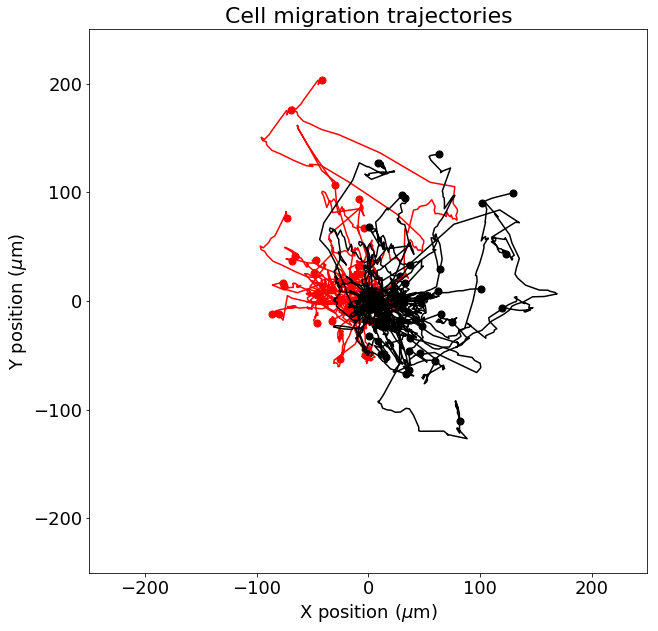

In [23]:
x = zerod_t_array[:,0,:]
y = zerod_t_array[:,1,:]
x_1 = x[x[:,-1] < 0]
y_1 = y[x[:,-1] < 0]
x_2 = x[x[:,-1] > 0]
y_2 = y[x[:,-1] > 0]


t = np.linspace(0,(n_frames-1)*t_inc,n_frames)

fig = plt.figure(figsize = (10,10),facecolor='w')
ax = fig.add_subplot(111)

export_path = 'export//2d_hairball//'
if not os.path.exists(export_path):
    os.makedirs(export_path)

segs_1 = np.zeros((len(x_1[:,0]), n_frames, 2), float)   
segs_1[:, :, 0] = x_1
segs_1[:, :, 1] = y_1

segs_2 = np.zeros((len(x_2[:,0]), n_frames, 2), float)   
segs_2[:, :, 0] = x_2
segs_2[:, :, 1] = y_2

#ax.set_xlim(np.nanmin(x)-5, np.nanmax(x)+5)
#ax.set_ylim(np.nanmin(y)-5, np.nanmax(y)+5)
ax.set_xlim(-250, 250)
ax.set_ylim(-250, 250)    
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax.set_xlabel('X position ($\mu$m)', fontsize=18)
ax.set_ylabel('Y position ($\mu$m)', fontsize=18)

line_segments_1 = LineCollection(segs_1,colors='red')
ax.add_collection(line_segments_1)
line_segments_2 = LineCollection(segs_2,colors='black')
ax.add_collection(line_segments_2)
ax.set_title('Cell migration trajectories', fontsize=22)
ax.scatter(x_1[:,-1],y_1[:,-1],s=50, c='red')
ax.scatter(x_2[:,-1],y_2[:,-1],s=50, c='black')
# plt.axis('equal')

plt.savefig(export_path + '2d_hairball_cmap_endPos_2color.png', format='png', dpi=600)
plt.show()   

### V.4.4 3D hairball style plot, with time as z axis


C:\Users\Davince\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


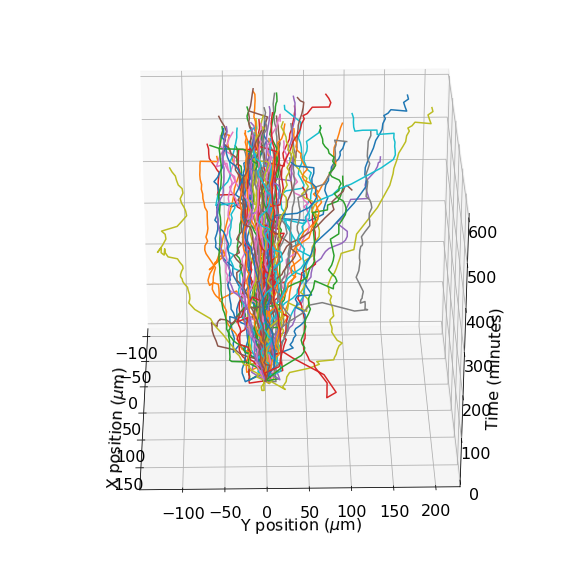

In [25]:
frames = []
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

export_path = 'export//3d_hairball//'
if not os.path.exists(export_path):
    os.makedirs(export_path)
       
for n in range(0,n_cells):

    x = zerod_t_array[n,0,:]
    y = zerod_t_array[n,1,:]
    t = np.linspace(0,n_frames*t_inc,n_frames)

    ax.plot(x, y, t)#, c=)
    ax.set_xlabel('X position ($\mu$m)', fontsize=16)
    ax.set_ylabel('Y position ($\mu$m)', fontsize=16)
    ax.set_zlabel('Time (minutes)', fontsize=16)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    

for angle in range(0, 360):
    ax.view_init(30, angle)
    
    # Draw the figure
    fig.canvas.draw()

    # Convert to numpy array, and append to list
    np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    np_fig = np_fig.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(np_fig)
    
imageio.mimsave(export_path + '/3d_hairball_test.gif', frames)
plt.show()

## V.5 statistical plot of cell migration parameters

### V.5.1 violin plot for cell area, perimeter, orientation, circularity, speed, directedness, turn angle, and direction autocorrelation

C:\Users\Davince\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\Davince\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\Davince\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1874: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\Davince\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


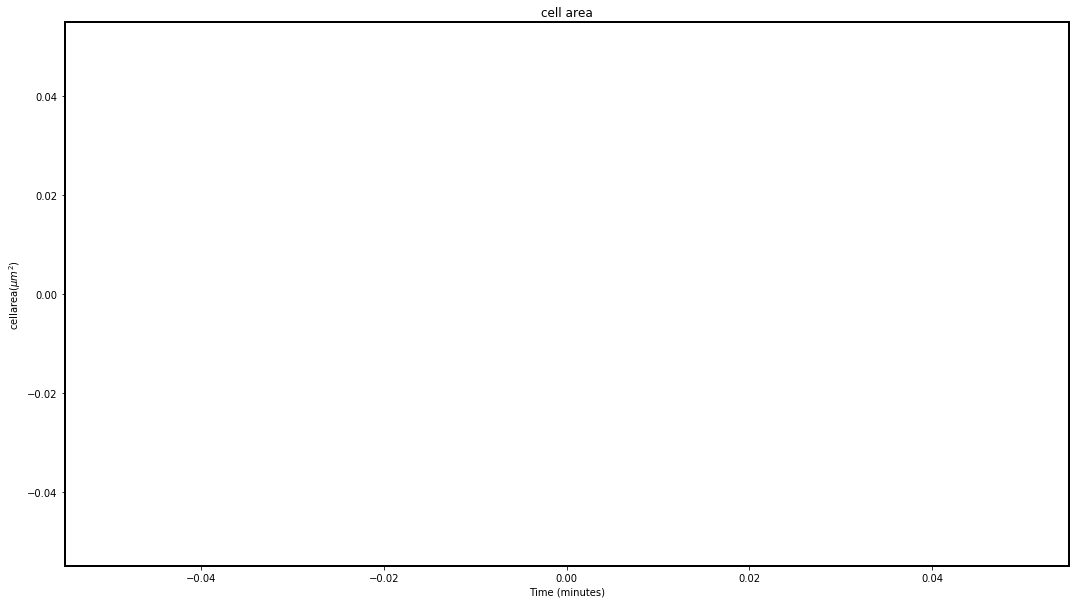

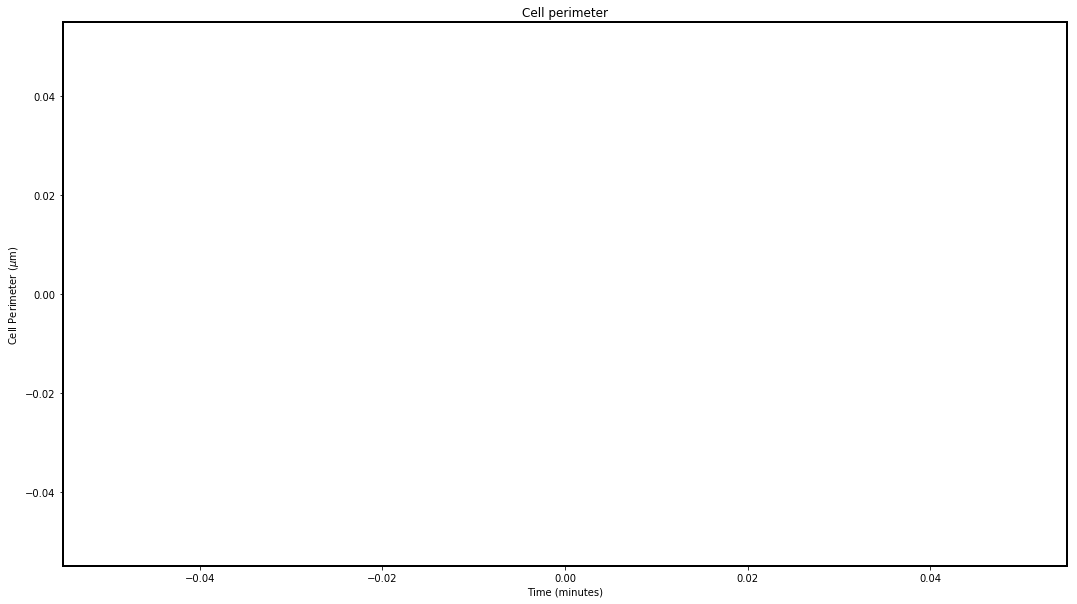

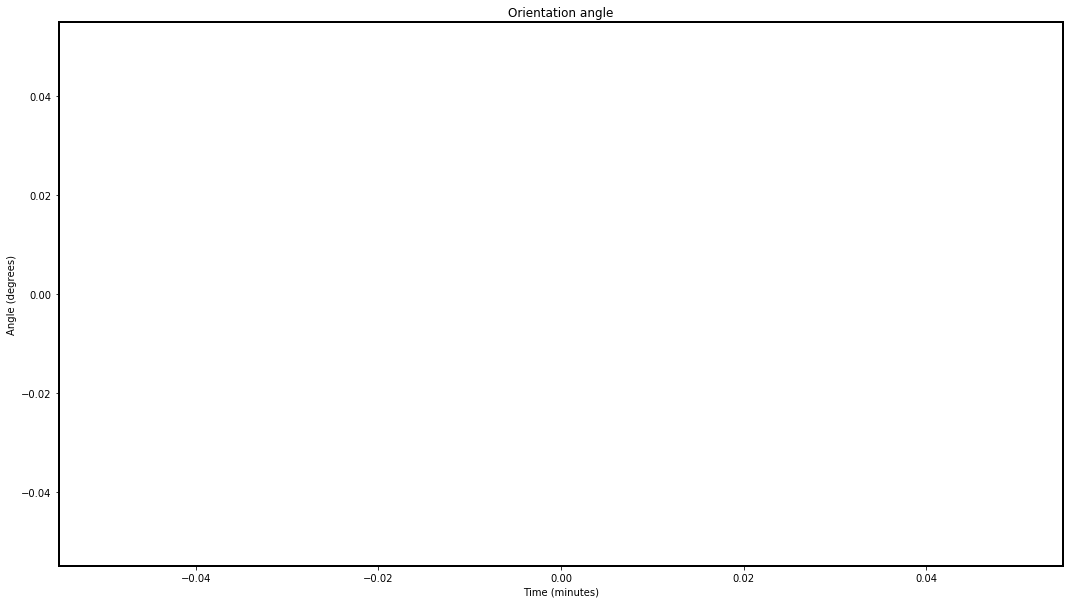

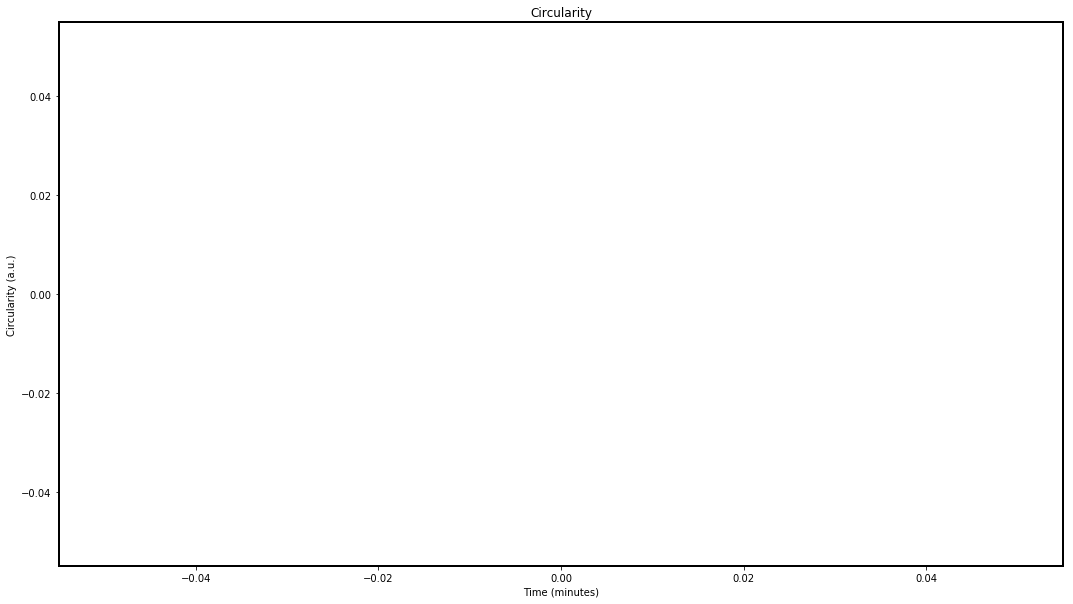

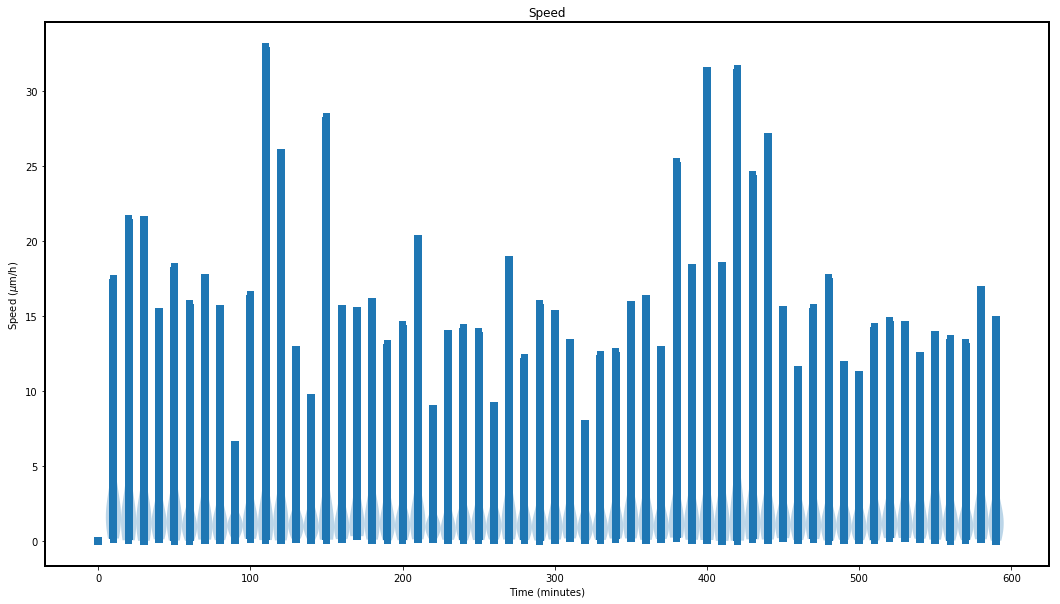

<Figure size 432x288 with 0 Axes>

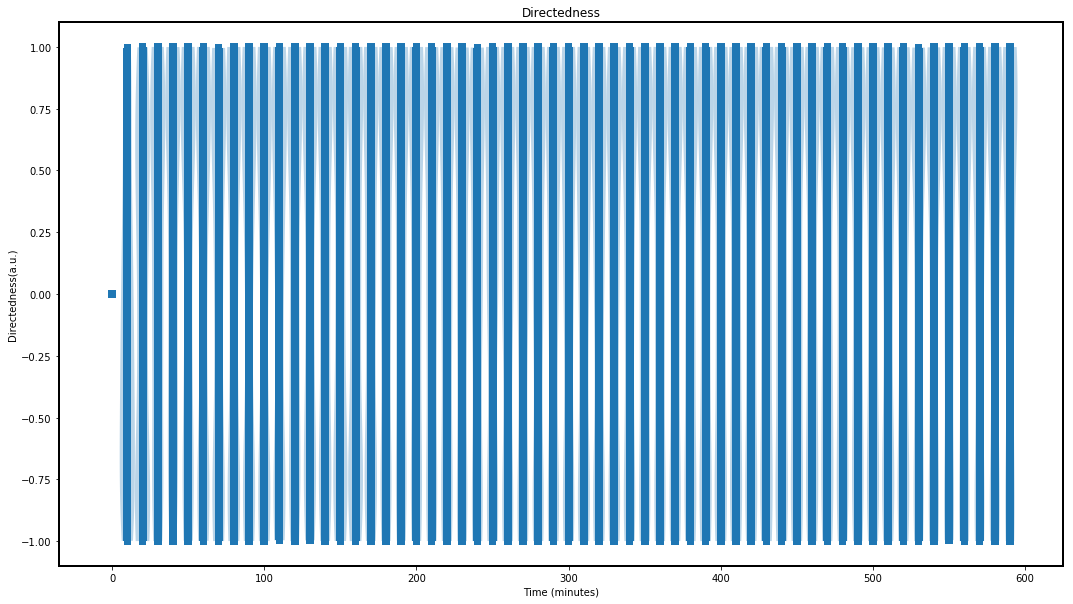

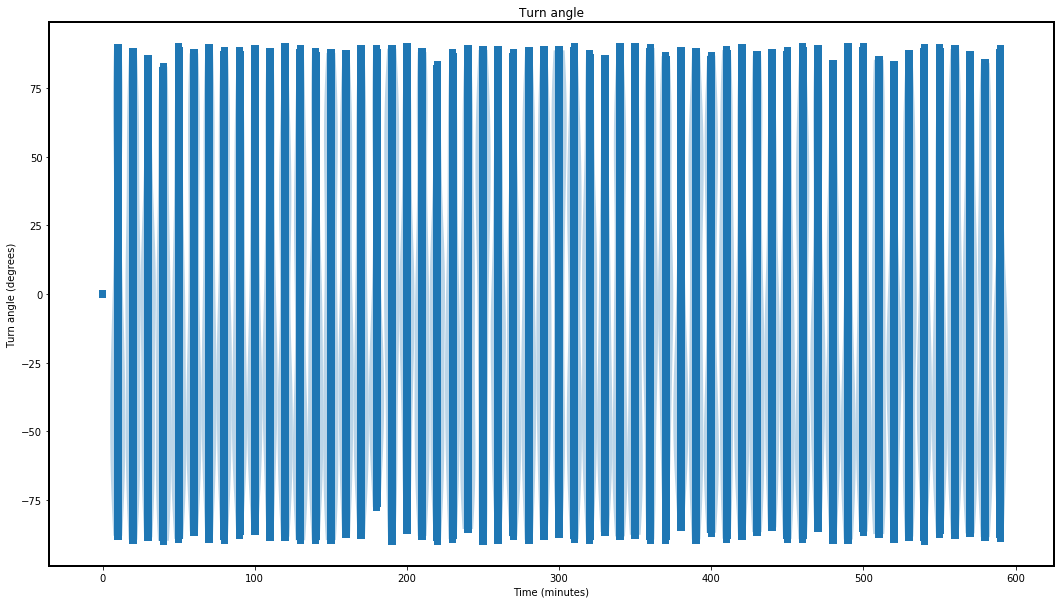

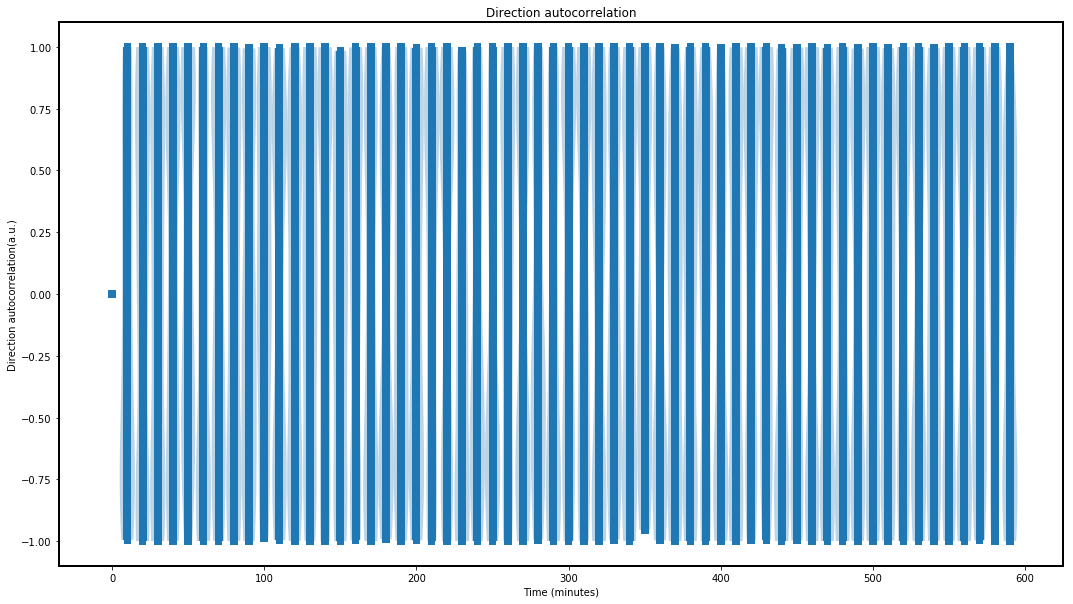

In [38]:
export_path = 'export//Violin plots//'
if not os.path.exists(export_path):
    os.makedirs(export_path)

fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
t=np.linspace(0,(n_frames-1)*t_inc, n_frames)
ax.violinplot(np.squeeze(props_t_array[:,2,:]), positions=t, widths=10, showmeans=False, showextrema=True, showmedians=True)
ax.set_title('cell area')
ax.set_ylabel('cellarea($\mu m^2$)')
ax.set_xlabel('Time (minutes)')

plt.savefig(export_path + 'area_violin.png', format='png', dpi=600)
plt.show()
fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax.violinplot(np.squeeze(props_t_array[:,3,:]),positions=t, widths = 10, showmeans=True, showextrema=True, showmedians=False)
ax.set_title('Cell perimeter')
ax.set_ylabel('Cell Perimeter ($\mu$m)')
ax.set_xlabel('Time (minutes)')

plt.savefig(export_path + 'perimeter_violin.png', format='png', dpi=600)
plt.show()
fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax.violinplot(np.squeeze(props_t_array[:,4,:]),positions=t, widths = 10, showmeans=True, showextrema=True, showmedians=False)
ax.set_title('Orientation angle')
ax.set_ylabel('Angle (degrees)')
ax.set_xlabel('Time (minutes)')

plt.savefig(export_path + 'angle_violin.png', format='png', dpi=600)
plt.show()
fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax.violinplot(np.squeeze(props_t_array[:,5,:]),positions=t, widths = 10, showmeans=True, showextrema=True, showmedians=False)
ax.set_title('Circularity')
ax.set_ylabel('Circularity (a.u.)')
ax.set_xlabel('Time (minutes)')

plt.savefig(export_path + 'circularity_violin.png', format='png', dpi=600)
plt.show()
fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax.violinplot(np.squeeze(props_t_array[:,10,:]),positions=t, widths = 10, showmeans=True, showextrema=True, showmedians=False)
ax.set_title('Speed')
ax.set_ylabel('Speed ($\mu$m/h)')
ax.set_xlabel('Time (minutes)')
plt.show()
plt.savefig(export_path + 'speed_violin.png', format='png', dpi=600)
plt.show()
fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax.violinplot(np.squeeze(props_t_array[:,11,:]),positions=t, widths = 10, showmeans=True, showextrema=True, showmedians=False)
ax.set_title('Directedness')
ax.set_ylabel('Directedness(a.u.)')
ax.set_xlabel('Time (minutes)')

plt.savefig(export_path + 'directedness_violin.png', format='png', dpi=600)
plt.show()

fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax.violinplot(np.squeeze(props_t_array[:,12,:]),positions=t, widths = 10, showmeans=True, showextrema=True, showmedians=False)
ax.set_title('Turn angle')
ax.set_ylabel('Turn angle (degrees)')
ax.set_xlabel('Time (minutes)')

plt.savefig(export_path + 'turnangle_violin.png', format='png', dpi=600)
plt.show()
fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax.violinplot(np.squeeze(props_t_array[:,13,:]),positions=t, widths = 10, showmeans=True, showextrema=True, showmedians=False)
ax.set_title('Direction autocorrelation')
ax.set_ylabel('Direction autocorrelation(a.u.)')
ax.set_xlabel('Time (minutes)')

plt.savefig(export_path + 'direction_autocorrelation_violin.png', format='png', dpi=600)
plt.show()

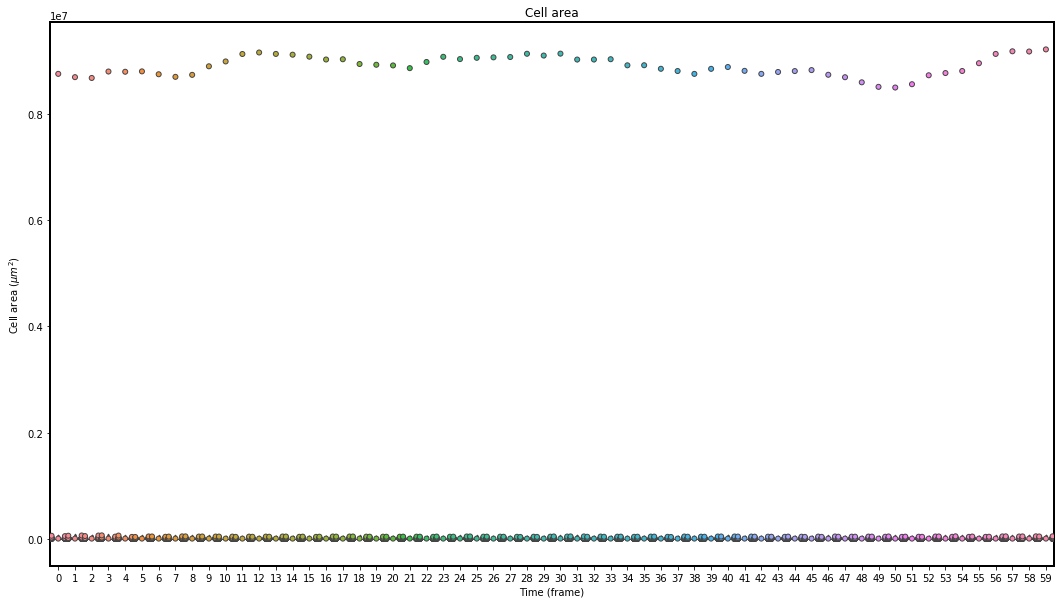

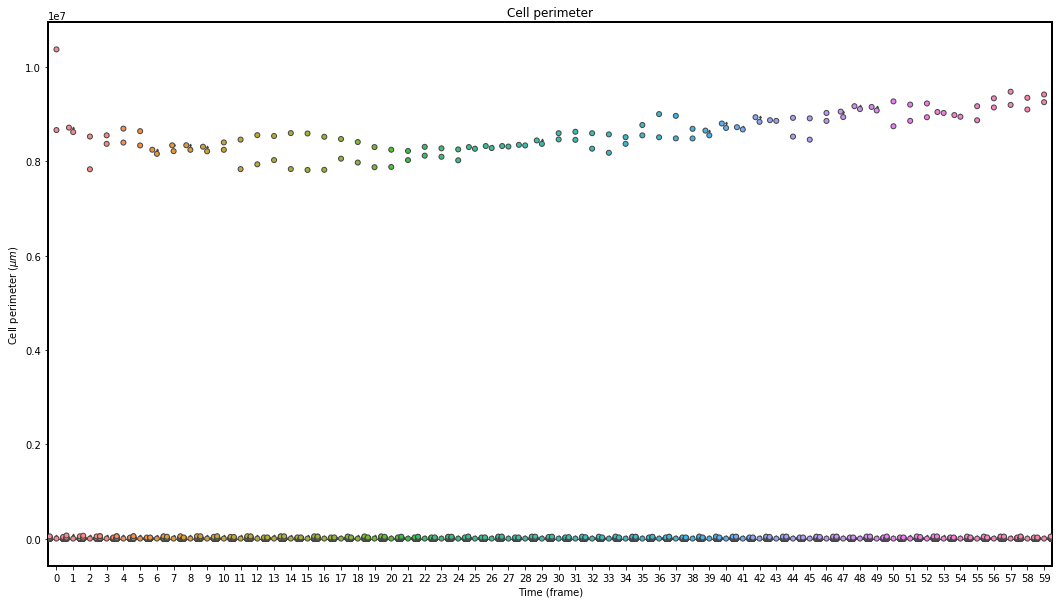

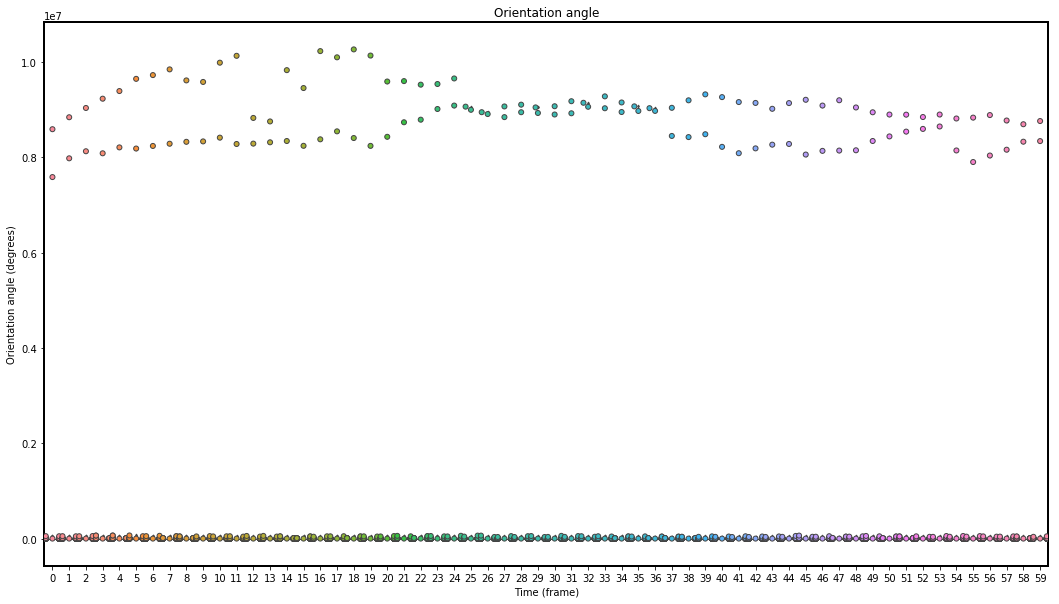

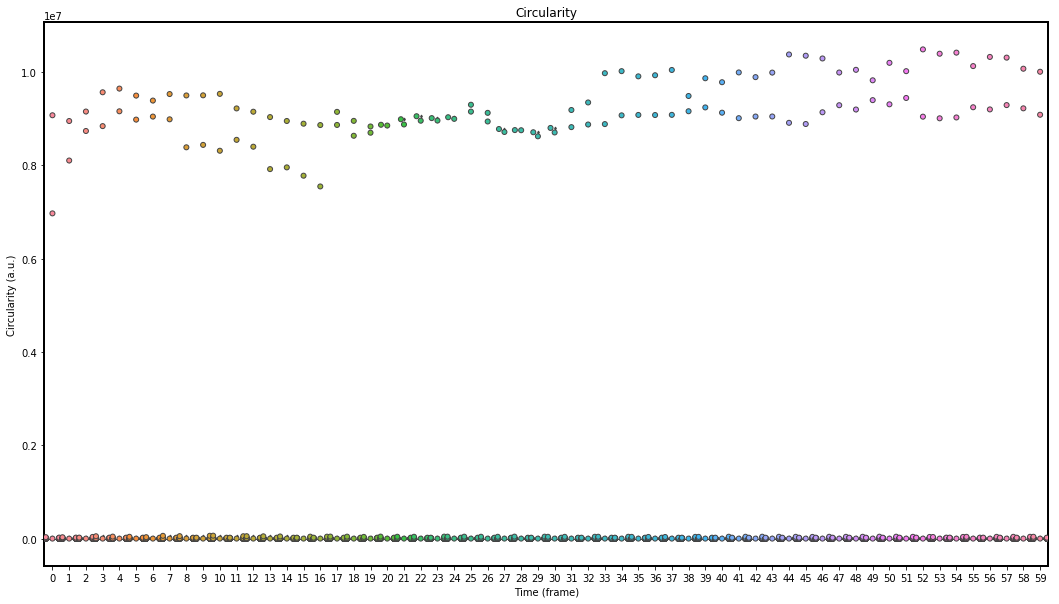

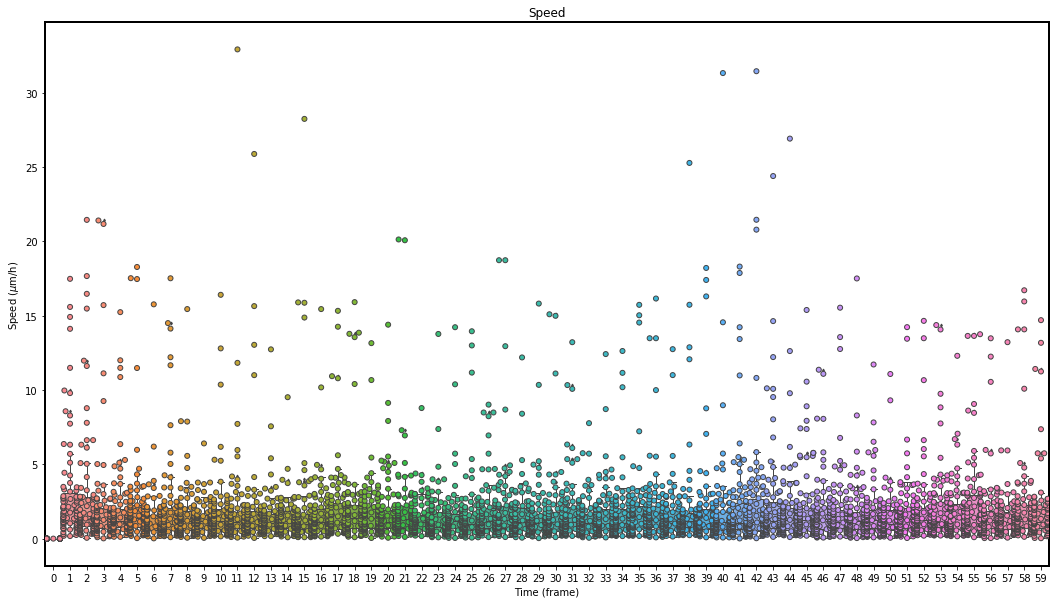

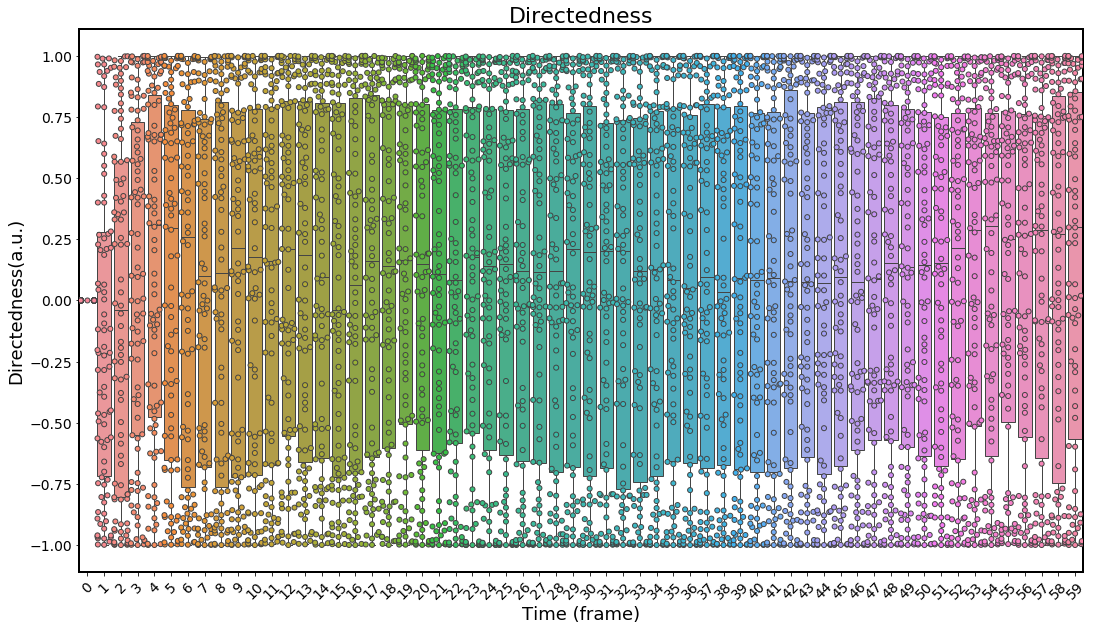

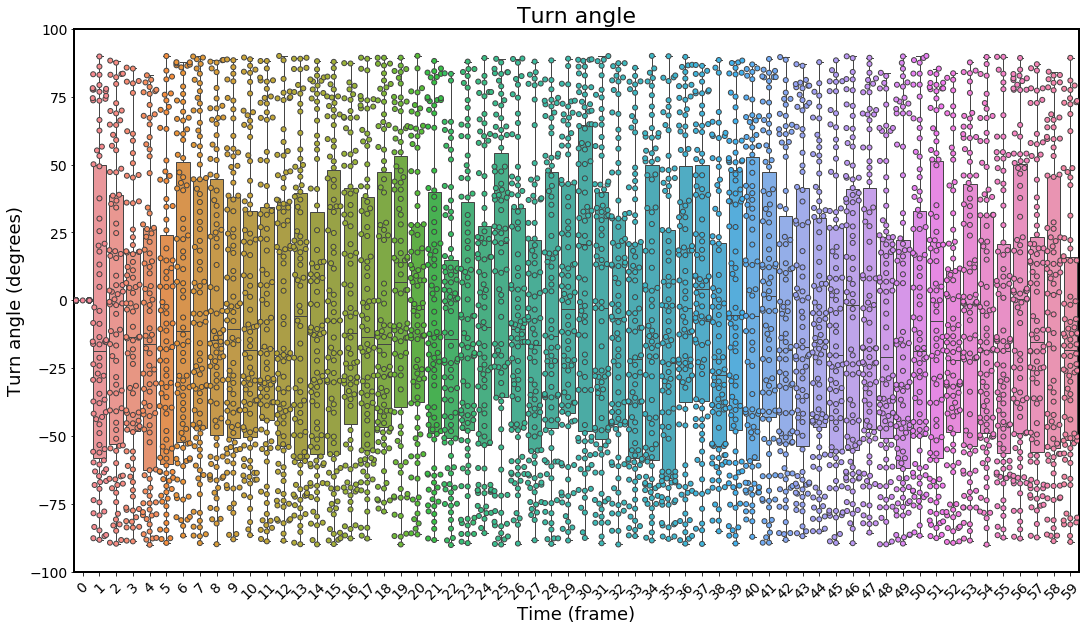

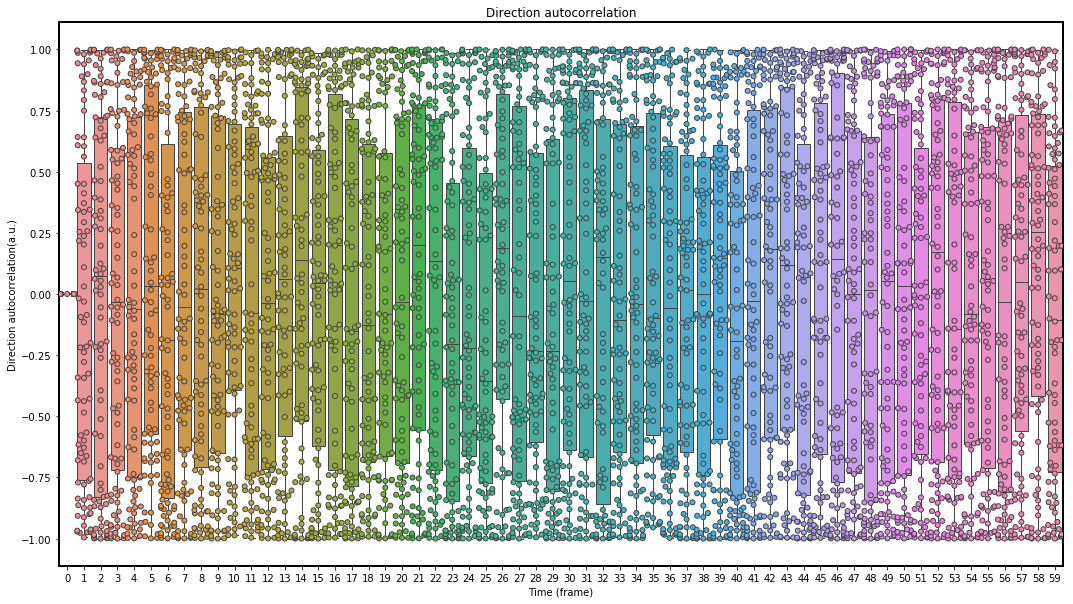

In [35]:
#box plots
export_path = 'export//boxplots//'

if not os.path.exists(export_path):
    os.makedirs(export_path)

t = np.linspace(0,(n_frames-1)*t_inc,n_frames)    

linewidth = 1
fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax = sns.boxplot(data=np.squeeze(props_t_array[:,2,:]),orient="v",linewidth=linewidth,fliersize=2, ax=ax)
ax = sns.swarmplot(data=np.squeeze(props_t_array[:,2,:]), orient="v", linewidth=linewidth, ax=ax)
ax.set_title('Cell area')
ax.set_ylabel('Cell area ($\mu m^2$)')
ax.set_xlabel('Time (frame)')
plt.savefig(export_path + 'cellarea_boxplot.png', format='png', dpi=600)
plt.show()




fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax = sns.boxplot(data=np.squeeze(props_t_array[:,3,:]),orient="v",linewidth=linewidth,fliersize=2, ax=ax)
ax = sns.swarmplot(data=np.squeeze(props_t_array[:,3,:]), orient="v", linewidth=linewidth, ax=ax)
ax.set_title('Cell perimeter')
ax.set_ylabel('Cell perimeter ($\mu m$)')
ax.set_xlabel('Time (frame)')
plt.savefig(export_path + 'perimeter_boxplot.png', format='png', dpi=600)
plt.show()

fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax = sns.boxplot(data=np.squeeze(props_t_array[:,4,:]),orient="v",linewidth=linewidth,fliersize=2, ax=ax)
ax = sns.swarmplot(data=np.squeeze(props_t_array[:,4,:]), orient="v", linewidth=linewidth, ax=ax)
ax.set_title('Orientation angle')
ax.set_ylabel('Orientation angle (degrees)')
ax.set_xlabel('Time (frame)')

plt.savefig(export_path + 'angle_boxplot.png', format='png', dpi=600)
plt.show()

fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax = sns.boxplot(data=np.squeeze(props_t_array[:,5,:]),orient="v",linewidth=linewidth,fliersize=2, ax=ax)
ax = sns.swarmplot(data=np.squeeze(props_t_array[:,5,:]), orient="v", linewidth=linewidth, ax=ax)
ax.set_title('Circularity')
ax.set_ylabel('Circularity (a.u.)')
ax.set_xlabel('Time (frame)')

plt.savefig(export_path + 'circularity_boxplot.png', format='png', dpi=600)
plt.show()

fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax = sns.boxplot(data=np.squeeze(props_t_array[:,10,:]),orient="v",linewidth=linewidth,fliersize=2, ax=ax)
ax = sns.swarmplot(data=np.squeeze(props_t_array[:,10,:]), orient="v", linewidth=linewidth, ax=ax)
ax.set_title('Speed')
ax.set_ylabel('Speed ($\mu$m/h)')
ax.set_xlabel('Time (frame)')

plt.savefig(export_path + 'speed_boxplot.png', format='png', dpi=600)
plt.show()

fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax = sns.boxplot(data=np.squeeze(props_t_array[:,11,:]),orient="v",linewidth=linewidth,fliersize=2, ax=ax)
ax = sns.swarmplot(data=np.squeeze(props_t_array[:,11,:]), orient="v", linewidth=linewidth, ax=ax)
ax.tick_params(axis = 'x', which = 'major', labelsize = 14, rotation=45)
ax.tick_params(axis = 'y', which = 'major', labelsize = 14, rotation=0)
ax.set_title('Directedness', fontsize=22)
ax.set_ylabel('Directedness(a.u.)', fontsize=18)
ax.set_xlabel('Time (frame)', fontsize=18)

plt.savefig(export_path + 'directedness_boxplot.png', format='png', dpi=600)
plt.show()

fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax = sns.boxplot(data=np.squeeze(props_t_array[:,12,:]),orient="v",linewidth=linewidth,fliersize=2, ax=ax)
ax = sns.swarmplot(data=np.squeeze(props_t_array[:,12,:]), orient="v", linewidth=linewidth, ax=ax)
ax.tick_params(axis = 'x', which = 'major', labelsize = 14, rotation=45)
ax.tick_params(axis = 'y', which = 'major', labelsize = 14, rotation=0)
ax.set_title('Turn angle', fontsize=22)
ax.set_ylabel('Turn angle (degrees)', fontsize=18)
ax.set_xlabel('Time (frame)', fontsize=18)

plt.savefig(export_path + 'turnangle_boxplot.png', format='png', dpi=600)
plt.show()

fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax = sns.boxplot(data=np.squeeze(props_t_array[:,13,:]),orient="v",linewidth=linewidth,fliersize=2, ax=ax)
ax = sns.swarmplot(data=np.squeeze(props_t_array[:,13,:]), orient="v", linewidth=linewidth, ax=ax)
ax.set_title('Direction autocorrelation')
ax.set_ylabel('Direction autocorrelation(a.u.)')
ax.set_xlabel('Time (frame)')

plt.savefig(export_path + 'direction_autocorrelation_boxplot.png', format='png', dpi=600)
plt.show()

# Adding: x="time",y="value", to the argument doesn't work with numpy array... maybe need to consider loading into a dataframe..
# Alternatively try a list of numpy arrays as data.

#Note: can specify whis (whiskers), default is 1.5
#whis : float, optional
#Proportion of the IQR past the low and high quartiles to extend the plot whiskers. Points outside this range will be identified as outliers.


### V.5.2 Timeseries line plot with with 95% confidence interval


C:\Users\Davince\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


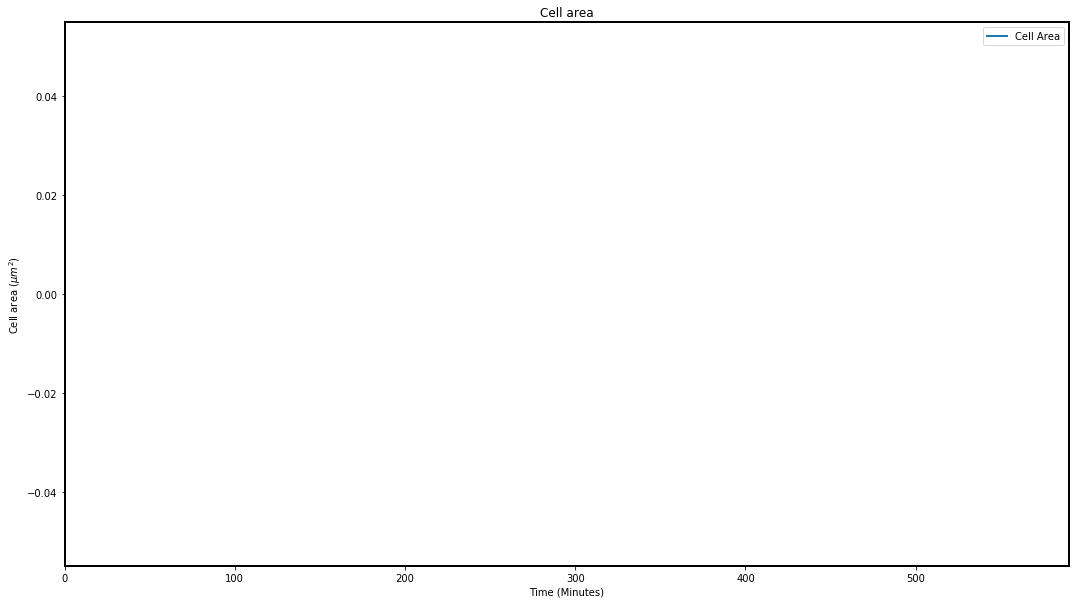

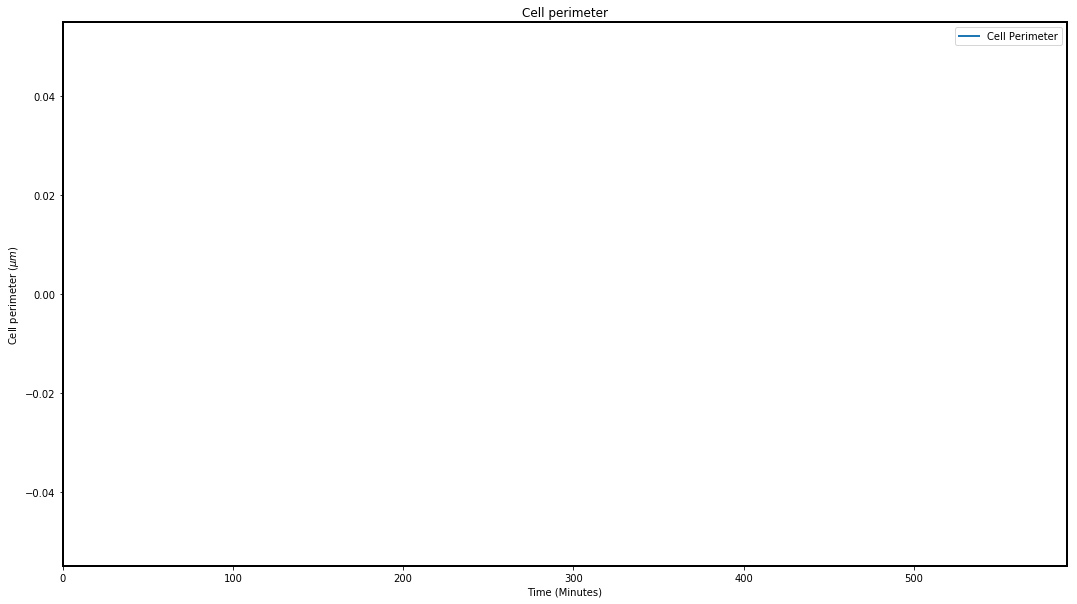

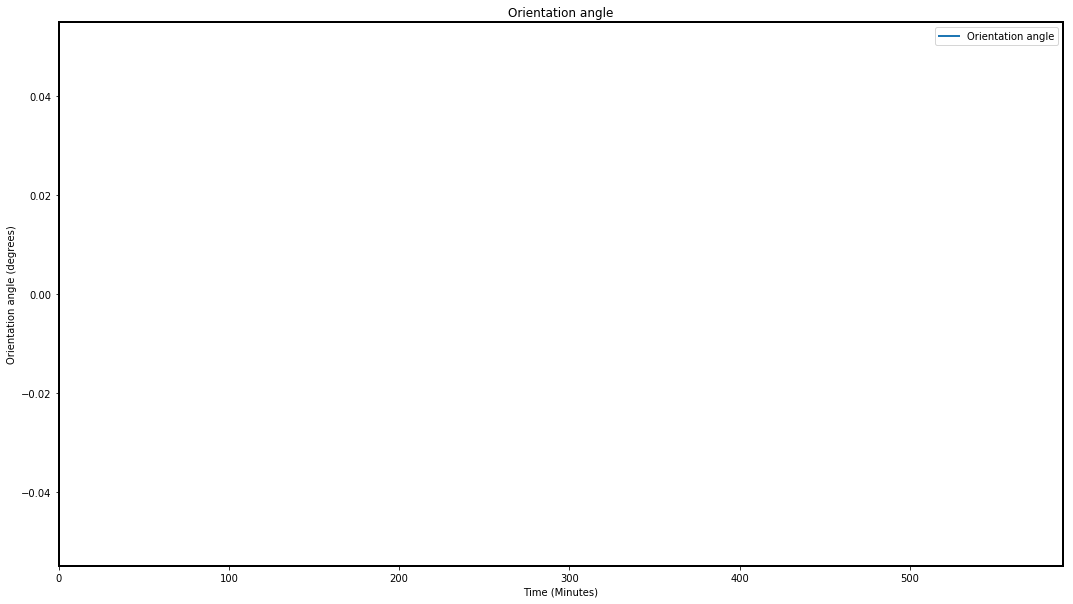

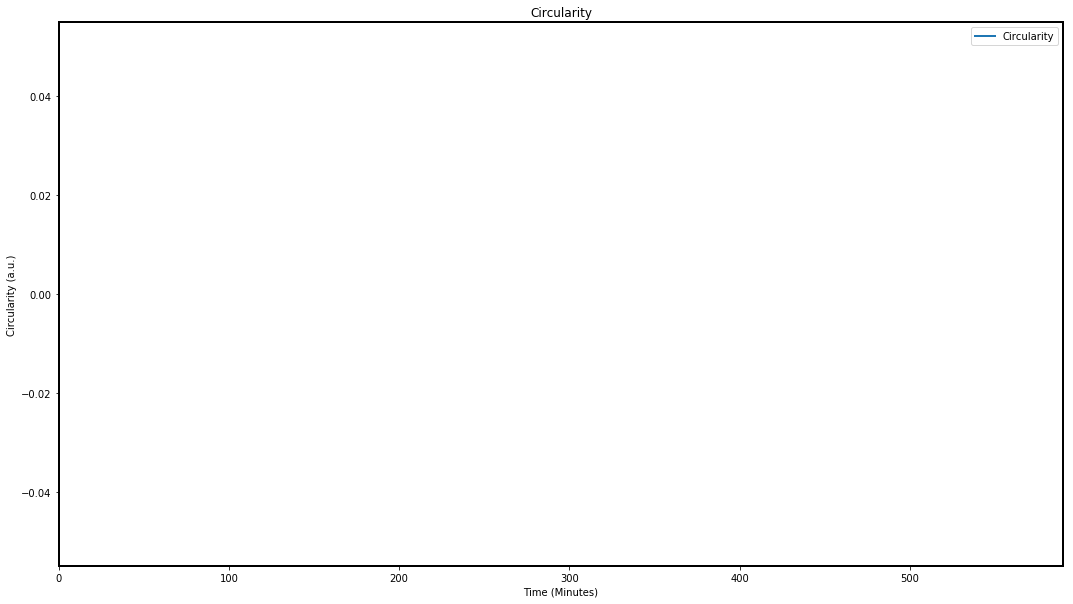

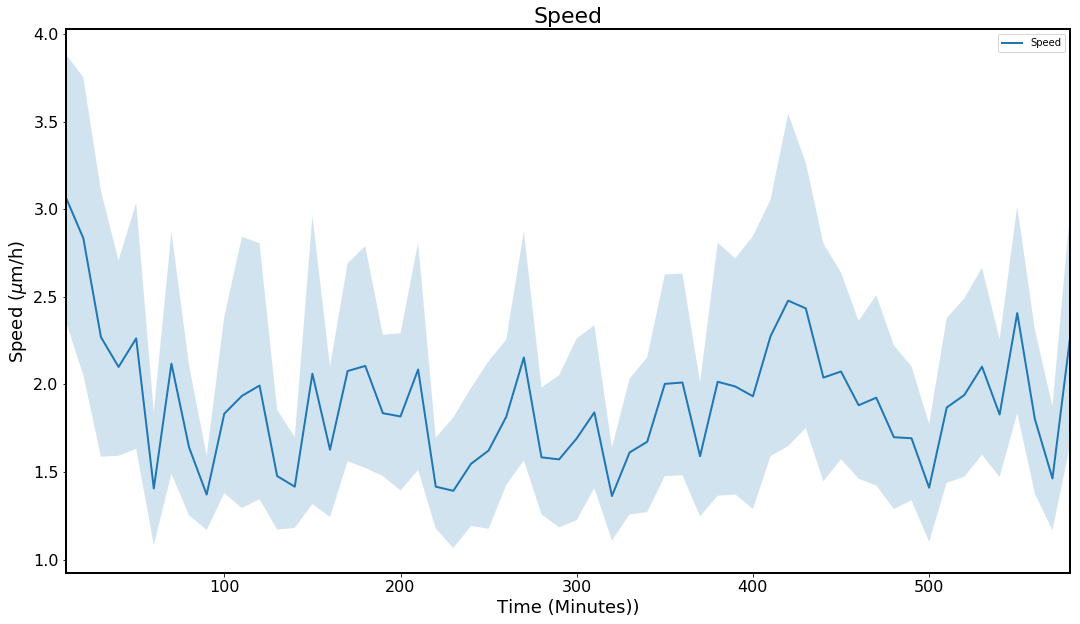

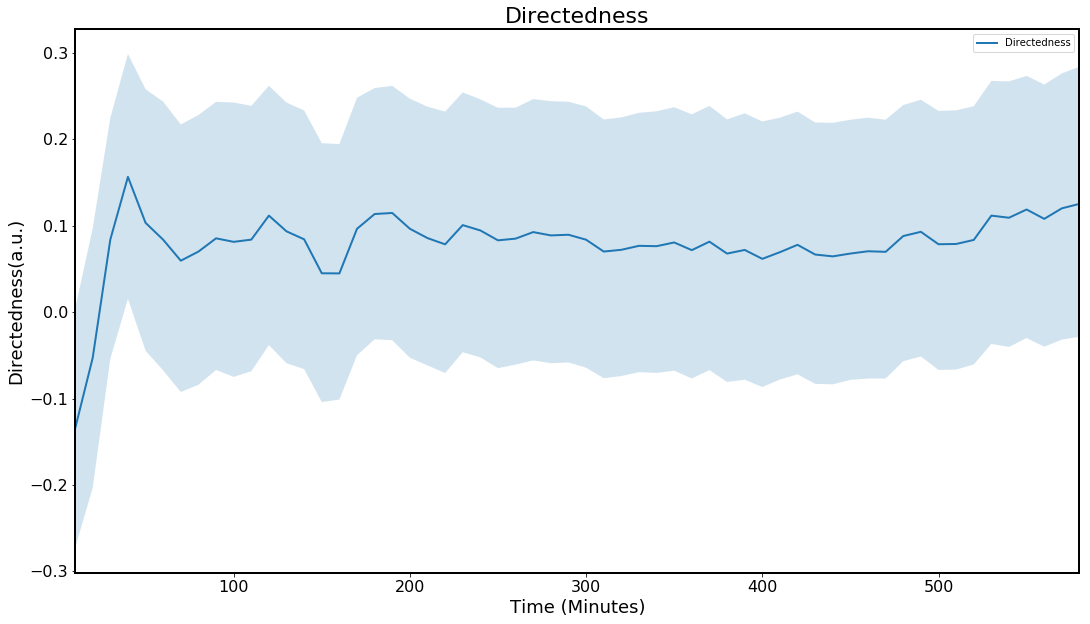

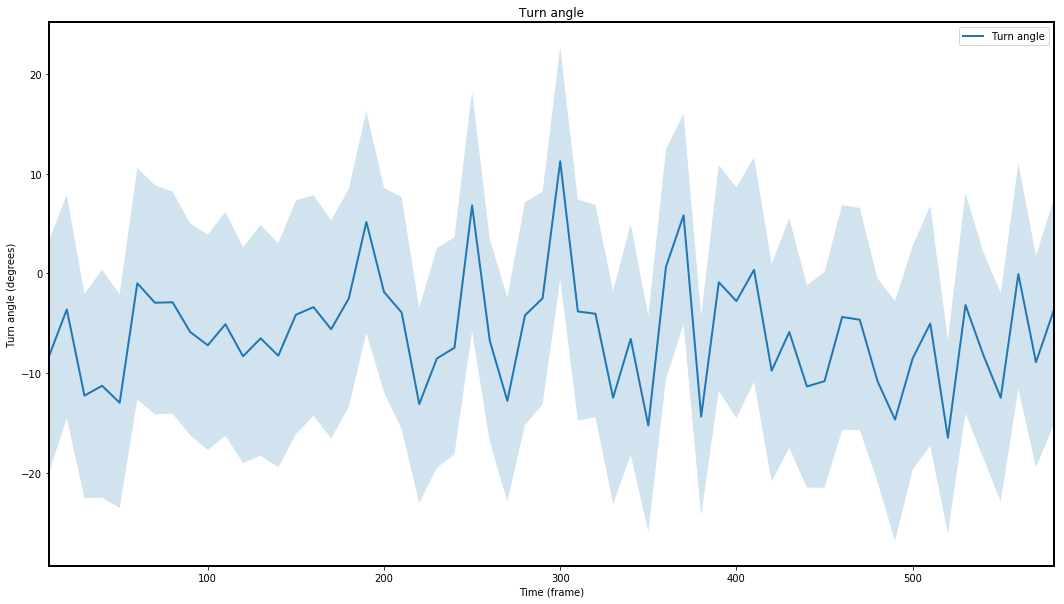

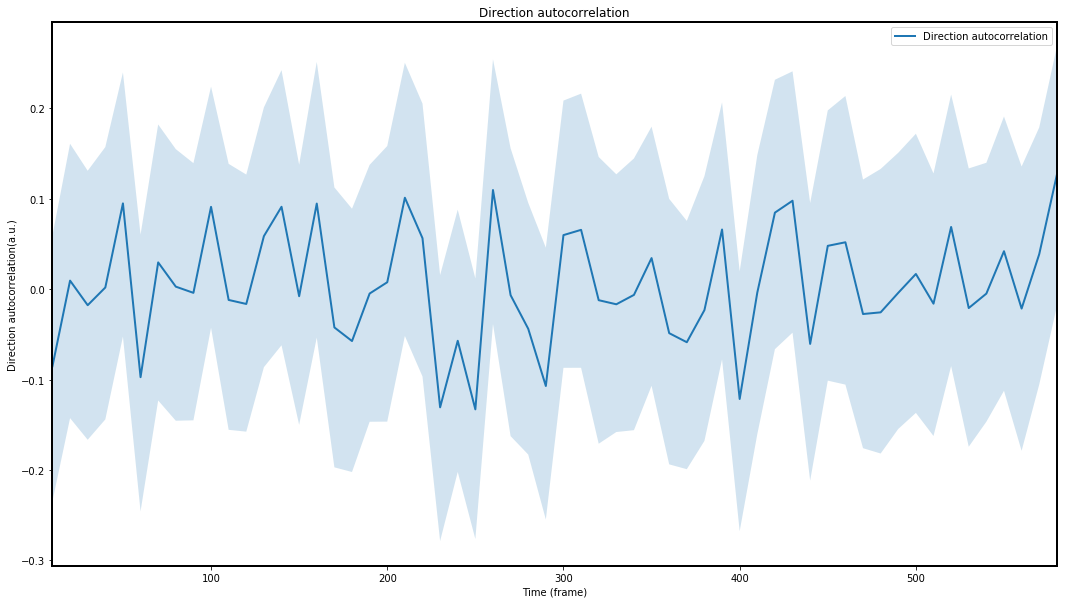

In [42]:
export_path = 'export//Timeseries plots//'

if not os.path.exists(export_path):
    os.makedirs(export_path)

    
    
t = np.linspace(0,(n_frames-1)*t_inc,n_frames)    
sns.set_style({'lines.linewidth': 2.0},{'axes.linewidth': 2.0})
linewidth = 1
fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax=sns.tsplot(np.squeeze(props_t_array[:,2,:]),time=t, condition='Cell Area', value='Cell Area ($\mu m^2$)', err_style="ci_band", ci=[0,95], ax=ax)
ax.set_title('Cell area')
ax.set_ylabel('Cell area ($\mu m^2$)')
ax.set_xlabel('Time (Minutes)')

plt.savefig(export_path + 'cellarea_timeseries.png', format='png', dpi=600)
plt.show()

fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax =sns.tsplot(np.squeeze(props_t_array[:,3,:]),time=t, condition='Cell Perimeter', value='Cell Perimeter ($\mu$m)',
              err_style="ci_band", ci=[0,95], ax=ax)
ax.set_title('Cell perimeter')
ax.set_ylabel('Cell perimeter ($\mu m$)')
ax.set_xlabel('Time (Minutes)')

plt.savefig(export_path + 'perimeter_timeseries.png', format='png', dpi=600)
plt.show()


fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax = sns.tsplot(np.squeeze(props_t_array[:,4,:]),time=t, condition='Orientation angle', value='Orientation Angle (degrees)',
              err_style="ci_band", ci=[0,95], ax=ax)
ax.set_title('Orientation angle')
ax.set_ylabel('Orientation angle (degrees)')
ax.set_xlabel('Time (Minutes)')

plt.savefig(export_path + 'angle_timeseries.png', format='png', dpi=600)
plt.show()

fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax = sns.tsplot(np.squeeze(props_t_array[:,5,:]),time=t, condition='Circularity', value='Circularity (a.u.)',
              err_style="ci_band", ci=[0,95], ax=ax)
ax.set_title('Circularity')
ax.set_ylabel('Circularity (a.u.)')
ax.set_xlabel('Time (Minutes)')

plt.savefig(export_path + 'circularity_timeseries.png', format='png', dpi=600)
plt.show()
fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax = sns.tsplot(np.squeeze(props_t_array[:,10,1:-1]),time=t[1:-1], condition='Speed', value='Speed ($\mu$m)/h',
              err_style="ci_band", ci=[0,95], ax=ax)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.set_title('Speed', fontsize=22)
ax.set_ylabel('Speed ($\mu$m/h)', fontsize=18)
ax.set_xlabel('Time (Minutes))', fontsize=18)

plt.savefig(export_path + 'speed_timeseries.png', format='png', dpi=600)
plt.show()
fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
ax = sns.tsplot(np.squeeze(props_t_array[:,11,1:-1]),time=t[1:-1], condition='Directedness', value='Directedness (a.u.)',
              err_style="ci_band", ci=[0,95], ax=ax)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.set_title('Directedness', fontsize=22)
ax.set_ylabel('Directedness(a.u.)', fontsize=18)
ax.set_xlabel('Time (Minutes)', fontsize=18)

plt.savefig(export_path + 'directedness_timeseries.png', format='png', dpi=600)
plt.show()

fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
#ax = sns.boxplot(data=np.squeeze(props_t_array[:,12,:]),orient="v",linewidth=linewidth,fliersize=2, ax=ax)
#ax = sns.swarmplot(data=np.squeeze(props_t_array[:,12,:]), orient="v", linewidth=linewidth, ax=ax)
ax = sns.tsplot(np.squeeze(props_t_array[:,12,1:-1]),time=t[1:-1], condition='Turn angle', value='Turn angle (degree)',
              err_style="ci_band", ci=[0,95], ax=ax)
ax.set_title('Turn angle')
ax.set_ylabel('Turn angle (degrees)')
ax.set_xlabel('Time (frame)')

plt.savefig(export_path + 'turnangle_timeseris.png', format='png', dpi=600)
plt.show()
fig = plt.figure(figsize=(18,10), facecolor='w')
ax = fig.add_subplot(111)
#ax = sns.boxplot(data=np.squeeze(props_t_array[:,13,:]),orient="v",linewidth=linewidth,fliersize=2, ax=ax)
#ax = sns.swarmplot(data=np.squeeze(props_t_array[:,13,:]), orient="v", linewidth=linewidth, ax=ax)
sns.tsplot(np.squeeze(props_t_array[:,13,1:-1]),time=t[1:-1], condition='Direction autocorrelation', value='Direction autocorrelation (a.u.)',
              err_style="ci_band", ci=[0,95], ax=ax)
ax.set_title('Direction autocorrelation')
ax.set_ylabel('Direction autocorrelation(a.u.)')
ax.set_xlabel('Time (frame)')

plt.savefig(export_path + 'direction_autocorrelation_boxplot.png', format='png', dpi=600)
plt.show()



### V.5.3 Rose plot at each time point
- See other nice examples: https://matplotlib.org/gallery/pie_and_polar_charts/polar_scatter.html#scatter-plot-on-polar-axis-confined-to-a-sector

In [25]:
# First have to process the angle data into bins

num_bins = 9
bins=np.linspace(0,180,num_bins+1) 
timestamps = np.linspace(0,n_frames*t_inc,n_frames+1)
angle_bins_t_array = np.empty([num_bins,n_frames])
orient_bins_t_array = np.empty([num_bins,n_frames])

# Compute bins for each frame of the image
for t in range(0,n_frames):                               
    angle_bins_t_array[:,t], edges =  np.histogram(props_t_array[:,4,t], bins=bins)
    orient_bins_t_array[:,t], edges =  np.histogram(props_t_array[:,8,t], bins=bins)

# Set scale for y values based on largest bin in the whole time array    
xmin = 0
xmax = 180

ymin = 0
ymax = np.ceil(np.max(angle_bins_t_array)) + 1


C:\Users\Davince\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\Davince\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: range parameter must be finite.

In [ ]:
frames = [] # List to contain all the frames of the gif
ti_tf = [] # List to contain the initial (ti) and final (tf) frames
export_path = 'export//Rose_histogram//'
if not os.path.exists(export_path):
    os.makedirs(export_path)
    
fig = plt.figure(frameon=True,facecolor='w')
fig.set_size_inches(10,10)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)


theta = np.linspace(0.0, np.pi, num_bins, endpoint=False)
width = np.pi / num_bins

for t in range(0,n_frames):
    ax.clear()
    radii = angle_bins_t_array[:,t]
    ax = plt.subplot(111, polar=True)
    bars = ax.bar(theta, radii, width=width, bottom=0) # bottom=bottom
    
    ax.set_title('Distribution of cell orientation angle at t = ' + str(int(timestamps[t])) + ' minutes', fontsize=18)
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    plt.ylim((ymin, ymax))   # set the ylim to ymin, ymax
    #ax.set_rorigin(-4)
    
    # Axis labels drawn at specified values of y and theta.
    ax.text(-np.pi/8, ymax/3, 'Number of cells', fontsize=15) # ymax/3 determined by trial and error
    #ax.text(np.pi/1.75, ymax + 3, 'Cell orientation angle(degrees)', fontsize=15)

    # Use custom colors and opacity
    for r, bar in zip(radii, bars):
        bar.set_facecolor(plt.cm.jet(r / 10.))
        bar.set_alpha(0.8)
        
    # Draw the figure
    fig.canvas.draw()

    # Convert to numpy array, and append to list
    np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    np_fig = np_fig.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(np_fig)
    
    # Save first and last frame as png
    if(t == 0): 
        plt.savefig(export_path + '/rose180_' + str(num_bins) + '_bins_ti.png', format='png', dpi=600)
    if(t == n_frames-1):
        plt.savefig(export_path + '/rose180_' + str(num_bins) + '_bins_tf.png', format='png', dpi=600)
        
imageio.mimsave(export_path + '/rose180_' + str(num_bins) + '_bins.gif', frames)


### V.5.4 Create polar scatter plot showing the distribution of cell orientations

In [ ]:
frames = [] # List to contain all the frames of the gif
export_path = 'export//polar_scatter//'

if not os.path.exists(export_path):
    os.makedirs(export_path)
    
ymin = 0
ymax = 100 # Currently these are arbitrary
    
    
fig = plt.figure(frameon=True,facecolor='w')
fig.set_size_inches(10,10)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

# Compute areas and colors
colors = np.linspace(0,1,len(props_t_array[:,4,t]))

for t in range(0,n_frames):
    ax.clear()
    ax.set_title('Distribution of cell orientation angle at t = ' + str(int(timestamps[t])) + ' minutes', fontsize=18)
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    ax.set_rorigin(-20)    
    
    # Axis labels drawn at specified values of y and theta.
    ax.text(np.pi/1.75, ymax + 20, 'Cell orientation angle (degrees)', fontsize=15)
    ax.text(-np.pi/4, 0, 'Cumulative displacement ($\mu$m)', fontsize=15) # ymax/3 determined by trial and error
    
    distance = np.sqrt(pow(props_t_array[:,0,t]-props_t_array[:,0,0],2) + pow(props_t_array[:,1,t]-props_t_array[:,1,0],2))
    size = props_t_array[:,2,t] / 10
    c = ax.scatter(props_t_array[:,4,t],distance , c=colors, s=size, cmap='hsv', alpha=0.75)
    plt.ylim((ymin, ymax))   # set the ylim to ymin, ymax

    # Draw the figure
    fig.canvas.draw()

    # Convert to numpy array, and append to list
    np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    np_fig = np_fig.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(np_fig)
    
    # Save first and last frame as png
    if(t == 0): 
        plt.savefig(export_path + '/polar_scatter_ti.png', format='png', dpi=600)
    if(t == n_frames-1):
        plt.savefig(export_path + '/polar_scatter_tf.png', format='png', dpi=600)
        
imageio.mimsave(export_path + '/polar_scatter_angle.gif', frames)

## V.6 compute histogram of frequency

C:\Users\Davince\Anaconda3\lib\site-packages\numpy\lib\function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Davince\Anaconda3\lib\site-packages\numpy\lib\function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\Davince\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\Davince\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\Davince\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\Davince\Anaconda3\lib\site-packages\ipykernel\__main__.py:52: DeprecationWarning: The binary mode of fromstring is 

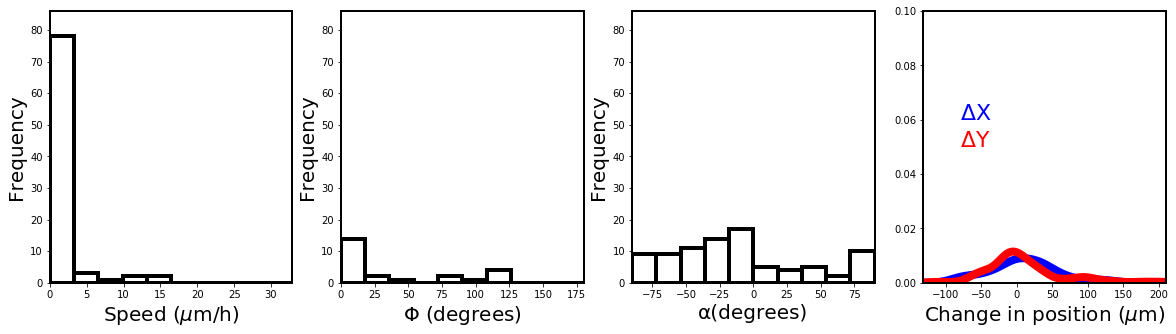

In [37]:
export_path = 'export//frequency_histogram_subplots//'
if not os.path.exists(export_path):
    os.makedirs(export_path)
    

sns.set_style({'lines.linewidth': 8.0},{'axes.linewidth': 2.0})
frames = []
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,  figsize=(20,5), facecolor='w')

for t in range(0,n_frames):
   
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    #speed
    ax1.hist(props_t_array[:,10,t], color='white',edgecolor='black', linewidth=4,range=(0, np.nanmax(props_t_array[:,10,:])))
    ax1.set_xlabel('Speed ($\mu$m/h)', fontsize=20)
    ax1.set_ylabel('Frequency', fontsize=20)
    ax1.set_xlim(0, np.nanmax(props_t_array[:,10,:]))
    ax1.set_ylim(0, n_cells)
    
    #angle
    ax2.hist(props_t_array[:,4,t], color='white',edgecolor='black', linewidth=4,range=(0, 180)) #props_t_array[:,8,t])
    ax2.set_xlabel('$\Phi$ (degrees)', fontsize=20)
    ax2.set_ylabel('Frequency', fontsize=20)
    ax2.set_xlim(0, 180)
    ax2.set_ylim(0, n_cells)
    #turn angle
    ax3.hist(props_t_array[:,12,t], color='white',edgecolor='black', linewidth=4,range=(np.nanmin(props_t_array[:,12,:]), np.nanmax(props_t_array[:,12,:])))
    ax3.set_xlabel('α(degrees)', fontsize=20)
    ax3.set_ylabel('Frequency', fontsize=20)
    ax3.set_xlim(np.nanmin(props_t_array[:,12,:]), np.nanmax(props_t_array[:,12,:]))
    ax3.set_ylim(0, n_cells)
    # plot of 2 variables
    p1=sns.kdeplot(zerod_t_array[:,0,t], shade=False, color="b", ax=ax4)
    p1=sns.kdeplot(zerod_t_array[:,1,t], shade=False, color="r", ax=ax4)
    #sns.plt.show()



    ax4.text(-80, 0.06, '$\Delta$X', fontsize=22, color='blue')
    ax4.text(-80, 0.05, '$\Delta$Y', fontsize=22, color='red')
    ax4.set_xlabel('Change in position ($\mu$m)', fontsize=20)
    ax4.set_xlim(np.nanmin(zerod_t_array[:,:,:])-5, np.nanmax(zerod_t_array[:,:,:])+5)
    ax4.set_ylim(0, 0.1)
    
    # Draw the figure
    fig.canvas.draw()

    # Convert to numpy array, and append to list
    np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    np_fig = np_fig.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(np_fig)
    
imageio.mimsave(export_path + '/frequency_histogram_subplots.gif', frames)
plt.show()
    
# plt.savefig(export_path + '2d_hairball_cmap_endPos_2color.png', format='png', dpi=600)
# plt.show()  
# ax4.set_ylabel('Probability', fontsize=20) # Find how to get it not overlapping

## V.7 Cell shape analysis
### V.7.1 load the ROI file paths

In [ ]:
roi_folder = 'ROISet//'

roi_filename = 'n_1_t_1'


# Test loading the first file
roi = read_roi_file(roi_folder + roi_filename +'.roi') # loads as dictionary
coords = np.column_stack((roi[roi_filename]['x'],roi[roi_filename]['y']))

### V.7.2 create a gif for each cell

In [ ]:
n_cells = 16
n_frames = 37
t_inc = 10 # Minutes
timestamps = np.linspace(0,(n_frames-1)*t_inc,n_frames)
fig = plt.figure(figsize = (10,10),facecolor='w')
ax = fig.add_subplot(111)
export_path = 'export_rois//contour_gifs//'
if not os.path.exists(export_path):
    os.makedirs(export_path)

for n in range(1,n_cells + 1):
    frames = []
    for t in range(1,n_frames + 1):
        curr_filename = 'n_' + str(n) + '_t_' + str(t)
        curr_roi = read_roi_file(roi_folder + curr_filename +'.roi') # loads as dictionary
        curr_coords = np.column_stack((curr_roi[curr_filename]['x'],curr_roi[curr_filename]['y']))


        # Draw the figure here.
        ax.clear()
        ax.axis('equal')

        window = 200
        x_center = np.mean(curr_coords[:,0])
        y_center = np.mean(curr_coords[:,1])
        
        ax.plot(curr_coords[:,0] - x_center,curr_coords[:,1] - y_center)
        ax.set_xlim(window / 2, -window / 2)
        ax.set_ylim(window / 2, -window / 2)
        ax.set_title('Cell ' + str(n) + ' at t = ' + str(int(timestamps[t-1])) + ' minutes')
        # Draw the figure
        fig.canvas.draw()

        # Convert to numpy array, and append to list
        np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        np_fig = np_fig.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(np_fig)
  
    imageio.mimsave(export_path + '/cell_' +str(n) + '.gif', frames)
      

### V.7.3 create a multi-panel subplots image for all cells in the experiment


In [ ]:
fig = plt.figure(figsize = (20,20),facecolor='w')
# f, axarr = plt.subplots(4, 4, sharex=True, sharey=True)

export_path = 'export_rois//contour_gifs//'
if not os.path.exists(export_path):
    os.makedirs(export_path)
frames = []

for t in range(1,n_frames + 1):
    for n in range(1,n_cells + 1):
        
    
        curr_filename = 'n_' + str(n) + '_t_' + str(t)
        curr_roi = read_roi_file(roi_folder + curr_filename +'.roi') # loads as dictionary
        curr_coords = np.column_stack((curr_roi[curr_filename]['x'],curr_roi[curr_filename]['y']))

        # Draw the figure here.
        ax = plt.subplot(4, 4, n )    
        ax.clear()
        ax.set_axis_off()

        window = 200
        x_center = np.mean(curr_coords[:,0])
        y_center = np.mean(curr_coords[:,1])

        ax.plot(curr_coords[:,0] - x_center,curr_coords[:,1] - y_center)
        ax.set_xlim(window / 2, -window / 2)
        ax.set_ylim(window / 2, -window / 2)
        ax.set_title('Cell ' + str(n))
        
    # Draw the figure
    fig.canvas.draw()

    # Convert to numpy array, and append to list
    np_fig = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    np_fig = np_fig.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(np_fig)
    
imageio.mimsave(export_path + 'small_multiples.gif', frames)
      